In [20]:
import cobra
import numpy as np
import json
from cobra import Model, Reaction, Metabolite
import os
import pandas as pd
import logging
logging.getLogger("cobra").setLevel(logging.ERROR)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Rectangle
import matplotlib.colors as colors
from matplotlib.lines import Line2D

import re  # Asegurémonos de importar el módulo re para usarlo en las funciones
import libsbml
import csv
from fuzzywuzzy import fuzz #custom library for doing metabolite mapping

import seaborn as sns
sns.set_style("white")

## Plot metric models
The idea is to perform a radar plot on each of the models, considering some the following metrics:
   - Number of reactions
   - Enzymatic reactions (reactions with associated genes)
   - Memote score
   - Number of genes
   - Number of metabolites
   - Unique metabolites (compartments)
   - Biomass metabolites
   - Dead ends
   - Metabolite participation (average participation of metabolites in reactions)

This notebook considers that files are organized in folders named as the different methods used, and each model with its respective organism name. Both models and memote reports (in .json format) are in the same folder.

## Metabolite mapping functions and functions to compute metrics and plot

In [3]:


# Función para normalizar identificadores (IDs) con eliminación de prefijos y sufijos
def normalize_id(identifier, DB):
    """
    Normaliza un identificador eliminando caracteres especiales, convirtiéndolo a minúsculas,
    y eliminando prefijos y sufijos específicos si están presentes.
    
    Args:
        identifier (str): El identificador a normalizar.

    Returns:
        str: El identificador normalizado.
    """
    
    
    # Elimina prefijos y sufijos específicos
    prefixes = ["M_"]#, "R_"]
    #NJT
    if DB == 'bigg':
        suffixes = ["_e", "_p", "_c"] #depende de DB
    elif DB=='kegg':
        suffixes=['__extr', '__cytop', '__vacu', '__in', '__nucl', '__chlo', '__mito', '__pero', '__out']
    elif DB=='metacyc':
        suffixes=["_e", "_p", "_c", "_t","_CCO__45__OUT", "_CCO__45__IN"]#"ccopmbacneg", "ccooutccoin"
    elif DB=='modelseed':
        suffixes = ["_c0", "_d0", "_g0", "_v0", "_w0", "_x0","_m0", "_n0", "_r0", "_e0", "_j0", "_c", '_b']
        prefixes = ['m_']
    else:
        print('Database not found!')
        
        
    for prefix in prefixes:
        if identifier.startswith(prefix):
            identifier = identifier[len(prefix):]
            break
    for suffix in suffixes:
        
        if identifier.endswith(suffix):
            #print(identifier)
            #print(suffix)
            identifier = identifier[:-len(suffix)]
            break

    # Elimina caracteres especiales
    identifier = cobra.io.sbml._f_specie(identifier)
    identifier = re.sub(r"[^a-zA-Z0-9]+", "", identifier)
    # Convierte a minúsculas
    identifier = identifier.lower()
    return identifier

# Función para normalizar identificadores (IDs) sin eliminación de prefijos y sufijos
def normalize_id_no_prefix_suffix(identifier):
    """
    Normaliza un identificador eliminando caracteres especiales y convirtiéndolo a minúsculas.

    Args:
        identifier (str): El identificador a normalizar.

    Returns:
        str: El identificador normalizado.
    """
    # Elimina caracteres especiales
    identifier = re.sub(r"[^a-zA-Z0-9]+", "", identifier)
    
    # Convierte a minúsculas
    identifier = identifier.lower()
    
    return identifier

def gen_df(route_sbml, db_sbml, mnx_only=False):
    #this_db is the db in which the sbml is coded
    # read SBML
    document = libsbml.readSBMLFromFile(route_sbml)
    models = document.getModel()
    # Extraer los IDs originales de las especies del modelo
    species_ids = [species.getId() for species in models.getListOfSpecies()]
    #print(species_ids)
    #reaction_ids = [reaction.getId() for reaction in models.getListOfReactions()] #future considerations
    # Normalizar los IDs de las especies
    normalized_species_ids = [normalize_id(i, db_sbml) for i in species_ids]
    #for i in range(10):
    #    print(species_ids[i])
    #    print(normalized_species_ids[i])
    #1. metanetx
    df_map = map_mnx(db_sbml, species_ids, normalized_species_ids)
    print('mapping metanetx')
    print(df_map.head())
    #2. modelseed
    if not mnx_only:
        if db_sbml!='bigg':
            print('bigg map')
            df_map = map_bigg(df_map, db_sbml)
        if db_sbml!='modelseed':
            print('mapping modelseed')
            df_map = map_modelseed(df_map, db_sbml)

        print(df_map.head())
        #add name and formula for fuzzy
        print('adding name and formula')
        df_map = add_name_formula(models, df_map, db_sbml)
        print(df_map.head())

        #3. fuzzy wuzzys
        if db_sbml!='metacyc':
            print('fuzzy meta')
            df_map = fuzzy_map_meta(df_map)
            print(df_map.head())
        if db_sbml!='kegg':
            df_map = fuzzy_map_kegg(df_map)
            print('fuzzy kegg')
            print(df_map.head())
        if db_sbml!='modelseed':
            df_map = fuzzy_map_modelseed(df_map)
            print('fuzzy ms')
            print(df_map.head())
        if db_sbml!='bigg':
            print('fuzzy bigg')
            df_map = fuzzy_map_bigg(df_map)
            print(df_map.head())
        
    df_map = df_map.fillna('')
    #assuming route is "to_plot/method/org.something"
    method = route_sbml.split('/')[2]
    org = route_sbml.split('/')[3].split('.')[0]
    df_map.to_csv(method+'_'+org+'_'+'.csv') #store mapping
    return(df_map)

def gen_mnx_db_dict(chem_xref_file, db_out):
    #NJ adapted
    #generates dict mapping from MNX to a db_out database based on file from metanetx
    db_prefix_dict = {'bigg': 'biggM:', 'metacyc': 'metacycM:', 'kegg': 'kegg.compound:', 'modelseed': 'seedM:'}
    db_dict = {}
    with open(chem_xref_file, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if  row[0].startswith(db_prefix_dict[db_out]):
                out_id = row[0][len(db_prefix_dict[db_out]):]  # Eliminar los primeros 9 caracteres ("metacycM:")
                MNX = row[1]
                if out_id.startswith('M_'):#why? I removed it 28/11
                    out_id = out_id[2:]
                db_dict[MNX] = out_id
    return db_dict

def map_mnx(this_db, species_ids, normalized_species_ids, chem_xref_file = r"./DB/chem_xref.tsv"):
    #Map ids model to mnx
    #STEP 1: metanetx
    # Ruta al archivo de referencias
    # Crear un diccionario para las conversiones de bigg
    this_db_dict = {}
    for species_id, normalized_species_id in zip(species_ids, normalized_species_ids):
        this_db_dict[species_id] = (normalized_species_id,)
    # Crear un diccionario para las conversiones de Metanetx
    db_prefix_dict = {'bigg': 'biggM:', 'metacyc': 'metacycM:', 'kegg': 'kegg.compound:', 'modelseed': 'seedM:'}
    #this_db
    metanetx_dict = {}
    
    with open(chem_xref_file, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if row[0].startswith(db_prefix_dict[this_db]): #especifico DB
                id_orig = row[0][len(db_prefix_dict[this_db]):]  # Eliminar los primeros 6 caracteres ("biggM:") #id_orig comes from the id of the DB
                id_norm = normalize_id_no_prefix_suffix(id_orig)
                value = row[1]
                metanetx_dict[id_orig] = (id_norm, value) #tuple instead of single value
                
    
    
    other_dbs = list(db_prefix_dict.keys())
    other_dbs.remove(this_db)
    mnx_db_dicts = dict()
    for db in other_dbs:
        mnx_db_dicts[db] = gen_mnx_db_dict(chem_xref_file, db)

    #print('mnx_db_dicts')
    #print(mnx_db_dicts)    
    # Crear un diccionario para las conversiones de metacyc
    #metacyc_dict = gen_mnx_db_dict(chem_xref_file, 'metacyc')
    #kegg_dict = gen_mnx_db_dict(chem_xref_file, 'kegg')
    #seed_dict = gen_mnx_db_dict(chem_xref_file, 'seed')

    # Convertir los diccionarios en DataFrames de pandas para bigg y Metanetx
    df_this = pd.DataFrame.from_dict(this_db_dict, orient='index', columns=['normalized_id'])
    df_this.index.name = 'original_id'

    # Crear una nueva columna llamada 'original_id' con los valores del índice
    df_this['original_id'] = df_this.index

    # Permutar las columnas y establecer 'normalized_id' como índice en df_bigg
    df_this = df_this[['normalized_id', 'original_id']].set_index('normalized_id', drop=True)
    # Convertir el diccionario metanetx_dict a un DataFrame de pandas
    df_metanetx = pd.DataFrame.from_dict(metanetx_dict, orient='index', columns=['normalized_id', 'MNX'])
    df_metanetx.index.name = 'original_id'
    print('df_metanetx')
    print(df_metanetx.head())
   
    # Crear una nueva columna llamada 'original_id' con los valores del índice y cambiar el nombre de la columna
    df_metanetx[this_db] = df_metanetx.index
    df_metanetx = df_metanetx.rename(columns={'original_id': this_db})
    
    # Permutar las columnas y establecer 'normalized_id' como índice en df_metanetx
    df_metanetx = df_metanetx[['normalized_id', 'MNX', this_db]].set_index('normalized_id', drop=True)

    # Realizar una fusión de los DataFrames de bigg y Metanetx en df_merged
    df_merged = df_this.merge(df_metanetx, how='left', left_index=True, right_index=True)
    #print('df_this.index')
    #print(df_this.index)
    #print('df_metanetx.index')
    #print(df_metanetx.index)
    
    df_no_data = df_merged.isna().all(axis=1)
    df_no_data.to_csv('no_data_rows.txt', header=False) #borrar?
    
    for db in other_dbs:
        #print(db)
        df_merged[db+'_mnx'] = df_merged['MNX'].map(mnx_db_dicts[db])
        
    # Restablecer el índice en df_merged y cambiar el nombre de la columna
    df_merged.reset_index(inplace=True)
    df_merged.rename(columns={'index': 'normalized_id'}, inplace=True)
    #print(df_merged.tail(10))
    return(df_merged)

def map_modelseed(df_merged, this_db, ruta_archivo = './DB/compounds.tsv'):

    # Definir la ruta del archivo TSV de modelseed
    ruta_archivo = './DB/compounds.tsv'

    # Definir la base de datos objetivo
    dict_obj_db = {'bigg':'BiGG', 'kegg': 'KEGG', 'metacyc':'MetaCyc'  }
    base_de_datos_objetivo = dict_obj_db[this_db]

    # Cargar el archivo TSV en un DataFrame de pandas
    df = pd.read_csv(ruta_archivo, sep='\t', header=None)

    # Crear un nuevo DataFrame para almacenar los identificadores
    df_nuevo = pd.DataFrame(columns=['Identificador', 'Modelseed_DB'])

    # Definir un patrón de búsqueda para "base_de_datos_objetivo: xxxx" con límites de palabra (\b)
    patron_busqueda = re.compile(rf'\b{base_de_datos_objetivo}: ([\w-]+)\b')

    # Iterar sobre las filas del DataFrame original y extraer los identificadores
    iden_dict = dict()
    for idx, row in df.iterrows():
        row_dict = dict()
        identificador_principal = row.iloc[0]
        for col in row[1:]:
            matches = patron_busqueda.findall(str(col))
            if matches:
                if len(matches)>1:
                    print(matches)
                identificador_encontrado = matches[0]
                #doing this with dicts instead: 
                row_dict['Identificador'] = identificador_encontrado
                row_dict['Modelseed_DB'] = identificador_principal
                iden_dict[idx] = row_dict
                # Agregar el identificador encontrado y su correspondiente 'Modelseed_DB' al DataFrame df_nuevo
                #df_nuevo = df_nuevo.append({'Identificador': identificador_encontrado, 'Modelseed_DB': identificador_principal}, ignore_index=True)
    df_nuevo = pd.DataFrame.from_dict(iden_dict, orient='index')
    # Realizar la combinación entre df_merged y df_nuevo utilizando 'Biggcyc_norm' e 'Identificador' como claves de combinación
    df_merged = df_merged.merge(df_nuevo, left_on=this_db, right_on='Identificador', how='left')

    # Eliminar la columna 'Identificador' del DataFrame resultante para limpiarlo
    df_merged.drop('Identificador', axis=1, inplace=True)
    
    return(df_merged)


def add_name_formula(models, df_merged, this_db, path_ms_db = './DB/compounds.tsv'):
    #input model in sbml
    #generate dicts with names and formulas
    #if this_db is modelseed, skip loading model and get formulas from database
    if this_db=='modelseed':
        df_ms = pd.read_csv(path_ms_db, sep='\t')
    name_dict = dict()
    formula_dict = dict()
    for met in models.getListOfSpecies():
        met_id = met.getIdAttribute()
        
        if met_id.startswith('M_'):
            met_id = met_id[2:]
        if this_db!='kegg':
            #clean compartment at the end (assuming it ends in "_c")
            #This could not be the case for other databases
            #print(met_id)
            if this_db=='modelseed':
                met_id = met_id[:-3]
            else:
                met_id = met_id[:-2]
            #print(met_id)
            
        if this_db=='modelseed':
            this_row = df_ms[df_ms['id']==met_id]
            if not this_row.empty:
                name_dict[met_id] = str(this_row['name'].iloc[0])
                formula_dict[met_id] = str(this_row['formula'].iloc[0])
            else:
                name_dict[met_id] = ''
                formula_dict[met_id] = ''
                
        else:
            name_dict[met_id] = met.getName()
             #met.getIdAttribute()
            notes = met.getNotesString()
            for n in notes.split('\n'):
                if 'FORMULA' in n:
                    formula = n.split(': ')[1].replace('</p>','')
                    formula_dict[met_id] = formula
            if not 'FORMULA' in notes:
                #print(notes)

                specie_fbc: "libsbml.FbcSpeciesPlugin" = met.getPlugin("fbc")
                if specie_fbc:
                    #charge = specie_fbc.getCharge()
                    formula = specie_fbc.getChemicalFormula() or ''
                    formula_dict[met_id] = formula
        # Agregar las columnas 'name' y 'formula' al DataFrame df_merged
    df_merged['name'] = ''
    df_merged['formula'] = ''

    # Iterar sobre cada fila del DataFrame df_merged y buscar el metabolito correspondiente en el modelo
    for index, row in df_merged.iterrows():
        #print(row[this_db])
        metabolito_id = row[this_db]#[2:]  # Obtén la cadena a partir del tercer carácter en adelante 
        #metabolito = modelo.metabolites.get_by_id(metabolito_id)

        # Obtener el nombre y la fórmula del metabolito
        if metabolito_id in name_dict.keys():
            #print('mapped name')
            nombre_metabolito = name_dict[metabolito_id]
            if metabolito_id in formula_dict.keys():
                formula_metabolito = formula_dict[metabolito_id]
            else:
                formula_metabolito = ''
        else:
            nombre_metabolito = ''
            formula_metabolito = ''

        # Agregar los valores de nombre y fórmula al DataFrame df_merged
        df_merged.at[index, 'name'] = nombre_metabolito
        df_merged.at[index, 'formula'] = formula_metabolito
        
    
    return(df_merged)
  

def map_bigg(df_merged, this_db, ruta_archivo='./DB/universal_model.json'):
    with open(ruta_archivo, 'r') as f:
        data = json.load(f)

    dict_obj_db = {'bigg':'BiGG', 'kegg': 'KEGG', 'metacyc':'MetaCyc', 'modelseed': 'modelseed' }
    base_de_datos_objetivo = dict_obj_db[this_db]
    # Crear una lista para almacenar los datos relevantes de los metabolitos
    metabolites = []
    for metabolite in data['metabolites']:
        bigg_id = metabolite['id']
        kegg_id = None
        seed_id = None
        metacyc_id = None
        mnx_id = None
        for annotation in metabolite['annotation']:
            #FALTA METACYC AQUI
            if 'kegg.compound' in annotation[1]:
                # Extraer el identificador kegg.compound de la anotación
                kegg_id = annotation[1].split('/')[-1]
            if 'seed.compound' in annotation[1]:
                # Extraer el identificador Modelseed de la anotación
                seed_id = annotation[1].split('/')[-1]
            if 'biocyc' in annotation[1]:
                # Extraer el identificador Metacyc de la anotación
                metacyc_id = annotation[1].split('/')[-1].replace('META:', '')
            if 'metanetx.chemical' in annotation[1]:
                # Extraer el identificador Metanetx de la anotación
                mnx_id = annotation[1].split('/')[-1]
            
        # Agregar los datos de metabolito a la lista
        metabolites.append({'BiGG': bigg_id, 'KEGG': kegg_id, 'modelseed': seed_id, 'MetaCyc': metacyc_id, 'Mnx': mnx_id})

    # Crear un DataFrame a partir de la lista de metabolitos
    df_metabolites = pd.json_normalize(metabolites)

    # Aplicar la función de normalización a la columna "See" después de reemplazar valores nulos con una cadena vacía
    df_metabolites[base_de_datos_objetivo+'_norm'] = df_metabolites[base_de_datos_objetivo].fillna('').apply(normalize_id_no_prefix_suffix)

    # Crear una nueva columna en df_merged para almacenar identificadores Bigg universales
    df_merged['bigg_DB'] = ''

    # Iterar sobre cada fila en df_merged
    for i, row in df_merged.iterrows():
        # Buscar si hay una coincidencia en "kegg_norm" en df_metabolites
        idx = df_metabolites.index[df_metabolites[base_de_datos_objetivo+'_norm'] == row['normalized_id']]
        if len(idx) > 0:
            # Si hay una coincidencia, asignar el valor de "Bigg" de df_metabolites
            df_merged.at[i, 'bigg_DB'] = df_metabolites.at[idx[0], 'BiGG']
        else:
            #print(df_metabolites.columns)
            # Si no hay una coincidencia, buscar una coincidencia en "Mnx" en ambos DataFrames
            idx = df_metabolites.index[df_metabolites['Mnx'] == row['MNX']]
            if len(idx) > 0:
                # Si hay una coincidencia, asignar el valor de "Bigg" de df_metabolites
                df_merged.at[i, 'bigg_DB'] = df_metabolites.at[idx[0], 'BiGG']


    #df_merged.to_csv('D:\\Master\\Master 2023\\Paper Methods\\IDs\\Test\\df_merged_with_bigg_universal.csv', index=False)
    df_merged = df_merged.fillna('')
    return(df_merged)


#Fuzzy wuzzy mapping 
def fuzzy_map_meta(df_merged, ruta_archivo = './DB/MetaCyc.csv', tol=80 ):
    #tol: tolerance for fuzzy wuzzy comparison. Default 80%
    
    #Columns in MetaCyc.csv
    #Column1;Column2;Column3;Column4;Column5;Column6;Column7;Column8;Column9
    #Compound Name;Chemical Formula;Mol. Wt.;SMILES;Species;Summary;Names;Pathways of compound;Object ID
    

    df_Metacyc = pd.read_csv(ruta_archivo, sep=';')

    # Mapeo directo nombre y fórmula
    df_merged['metacyc_NF_direc'] = ''  # Inicialmente, configuramos kegg_NF_direc en blanco

    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        formula = row['formula'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        #Column7: Names
        #Column2: Chemical formula
        if len(formula)>0:
            match = df_Metacyc[(df_Metacyc['Column7'].str.strip().str.lower() == name) & (df_Metacyc['Column2'].str.strip().str.lower() == formula)]
        else:
            match = df_Metacyc[(df_Metacyc['Column7'].str.strip().str.lower() == name)]
        if not match.empty:
            df_merged.at[index, 'metacyc_NF_direc'] = match.iloc[0]['Column9']
            #Column9: Object ID
    # Mapeo opciones nombre y fórmula
    df_merged['metacyc_opc'] = ''  # Creamos una nueva columna para el mapeo de opciones

    for index, row in df_merged.iterrows():
        name = row['name']
        formula = row['formula']
        if not df_merged.at[index, 'metacyc_NF_direc']:  # Solo si kegg_NF_direc está en blanco
            matches = df_Metacyc[(df_Metacyc['Column7'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol) & (df_Metacyc['Column2'].apply(lambda x: fuzz.ratio(str(x), str(formula))) > tol)]
            if not matches.empty:
                df_merged.at[index, 'metacyc_opc'] = ', '.join(matches['Column9'].tolist())
                print(f"Identificadores agregados para {name} - {formula}: {matches['Column9'].tolist()}")
                
                
    return(df_merged)

def fuzzy_map_kegg(df_merged, ruta_archivo = './DB/Kegg_progreso_3.csv', tol=80):
    #tol: tolerance for fuzzy wuzzy comparison. Default 80%
    # Cargar el archivo en un DataFrame
    df_kegg = pd.read_csv(ruta_archivo)

    # Mapeo directo nombre y fórmula
    df_merged['kegg_NF_direc'] = ''  # Inicialmente, configuramos kegg_NF_direc en blanco

    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        formula = row['formula'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        
        if len(formula)>0:
            match = df_kegg[(df_kegg['NAME'].str.strip().str.lower() == name)]
        else:
            match = df_kegg[(df_kegg['NAME'].str.strip().str.lower() == name) & (df_kegg['FORMULA'].str.strip().str.lower() == formula)]
        if not match.empty:
            df_merged.at[index, 'kegg_NF_direc'] = match.iloc[0]['ENTRY']

    # Mapeo opciones nombre y fórmula
    df_merged['kegg_opc'] = ''  # Creamos una nueva columna para el mapeo de opciones

    for index, row in df_merged.iterrows():
        name = row['name']
        formula = row['formula']
        if not df_merged.at[index, 'kegg_NF_direc']:  # Solo si kegg_NF_direc está en blanco
            if len(formula)>0:
                matches = df_kegg[(df_kegg['NAME'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol) & (df_kegg['FORMULA'].apply(lambda x: fuzz.ratio(str(x), str(formula))) > tol)]
            else:
                matches = df_kegg[(df_kegg['NAME'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol)]
            
            if not matches.empty:
                df_merged.at[index, 'kegg_opc'] = ', '.join(matches['ENTRY'].tolist())
                print(f"Identificadores agregados para {name} - {formula}: {matches['ENTRY'].tolist()}")
    
    return(df_merged)

def fuzzy_map_modelseed(df_merged, ruta_archivo = './DB/compounds.tsv', tol=80):\
    #tol: tolerance for fuzzy wuzzy comparison. Default 80%
    # Cargar el archivo en un DataFrame
    df_modelseed = pd.read_csv(ruta_archivo, sep='\t', usecols=['id', 'name', 'formula'])

    # Mapeo directo nombre y fórmula
    df_merged['modelseed_NF_direc'] = ''  # Inicialmente, configuramos modelseed_NF_direc en blanco

    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        formula = row['formula'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        match = df_modelseed[(df_modelseed['name'].str.strip().str.lower() == name) & (df_modelseed['formula'].str.strip().str.lower() == formula)]
        if not match.empty:
            df_merged.at[index, 'modelseed_NF_direc'] = match.iloc[0]['id']

    # Mapeo opciones nombre y fórmula
    df_merged['modelseed_opc'] = ''  # Creamos una nueva columna para el mapeo de opciones

    for index, row in df_merged.iterrows():
        name = row['name']
        formula = row['formula']
        if not df_merged.at[index, 'modelseed_NF_direc']:  # Solo si modelseed_NF_direc está en blanco
            matches = df_modelseed[(df_modelseed['name'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol) & (df_modelseed['formula'].apply(lambda x: fuzz.ratio(str(x), str(formula))) > tol)]
            if not matches.empty:
                df_merged.at[index, 'modelseed_opc'] = ', '.join(matches['id'].tolist())
                print(f"Identificadores agregados para {name} - {formula}: {matches['id'].tolist()}")
    
    return(df_merged)

def fuzzy_map_bigg(df_merged, tol=80, ruta_archivo='./DB/Name_formula_bigg.csv'):
    df_name_formula = pd.read_csv('./DB/Name_formula_bigg.csv')

    # Mapeo directo nombre y fórmula
    df_merged['bigg_NF_direc'] = ''  # Inicialmente, configuramos bigg_NF_direc en blanco

    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        match = df_name_formula[(df_name_formula['name_2'].str.strip().str.lower() == name)]
        if not match.empty:
            df_merged.at[index, 'bigg_NF_direc'] = match.iloc[0]['id']

    # Mapeo opciones nombre y fórmula
    df_merged['bigg_opc'] = ''  # Creamos una nueva columna para el mapeo de opciones

    for index, row in df_merged.iterrows():
        name = row['name']
        if not df_merged.at[index, 'bigg_NF_direc']:  # Solo si bigg_NF_direc está en blanco
            matches = df_name_formula[(df_name_formula['name_2'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol)]
            if not matches.empty:
                df_merged.at[index, 'bigg_opc'] = ', '.join(matches['id'].tolist())
                print(f"Identificadores agregados para {name}: {matches['id'].tolist()}")
    
    return(df_merged)

def map_metabolites(met_list, model_path, this_db, db_out, mnx_only=False):
    #met list: list with metabolite ids from model 
    #model_path: path to sbml model (with info name formula)
    #this_db (string): database in which this model is based
    #db_out (string): database to which we are going to map
    
    df_map = gen_df(model_path, this_db, mnx_only)
    df_map = df_map.fillna('')
    print(met_list[0:20])
    
    
    #decide on metabolites
    met_map_dict = dict()
    for met in met_list:
        map_met=''
        norm_met = normalize_id(met, this_db)
        row = df_map[df_map['normalized_id']==norm_met]
        #print(met)
        #print('mapping row')
        #print(row)
        if db_out=='MNX':
            #print('db_out is mnx')
            if not row['MNX'].empty:
                #print('row mnx not empty')
                map_met = row['MNX'].iloc[0]
            else:
                print('is empty?')
                print(row)
        else:
            if db_out+'_mnx' in df_map.columns:
                if len(row[db_out+'_mnx'])>0:
                    map_met = row[db_out+'_mnx'].iloc[0]
                else:
                    map_met = ''
            if map_met=='': #no direct map available (column) or map available but empty
                if db_out=='bigg' and 'bigg_DB' in df_map.columns:
                    if not row['bigg_DB'].empty:
                        #check map bigg
                        #print(row)
                        map_met = row['bigg_DB'].iloc[0]
                elif db_out=='modelseed' and 'modelseed_DB' in df_map.columns:
                    #check map modelseed
                    if not row['modelseed_DB'].empty:
                        map_met = row['modelseed_DB'].iloc[0]
            if map_met=='':#no effective map before, map "Name formula" (fuzzy)  
                if db_out+'_NF_direc' in df_map.columns:
                    #from modelseed this will never work (no formulas)
                    if not row[db_out+'_NF_direc'].empty:
                        map_met = row[db_out+'_NF_direc'].iloc[0]
                        print(map_met)
            if map_met=='':
                if db_out+'_opc' in df_map.columns:
                    if not row[db_out+'_opc'].empty:
                        map_met=row[db_out+'_opc'].iloc[0]
            if map_met=='':
                print(met)
                print(df_map.head(1))
                #print(row)
        
        met_map_dict[met] = map_met   
        
    return(met_map_dict)

def get_memote_score(test_dict):
    
    #Computes the memote (global) score based on info provided by memote
    #Input: dict from parsed json from memote analysis
    #Output: memote score
    
    #TO DO:
    #     - Check scores of everything but consistency
    #     - Report inconsistencies with regards to memote scores from their own report (github?)
    
    #####Consistency
    s_cons = 1 - test_dict['test_stoichiometric_consistency']['metric'] #STOICHIOMETRIC CONSISTENCY
    m_bal = 1 - test_dict['test_reaction_mass_balance']['metric'] #MASS BALANCE #unbalanced reactions
    c_bal = 1 - test_dict['test_reaction_charge_balance']['metric'] #CHARGE BALANCE #unbalanced reactions
    m_conn = 1 - test_dict['test_find_disconnected']['metric'] #METABOLITE CONNECTIVITY #percentage of metabolites not associated with reactions
    u_flux = 1-test_dict['test_find_reactions_unbounded_flux_default_condition']['metric'] #UNBOUNDED FLUX IN DEFAULT MEDIUM

    cons_score = (s_cons + m_bal + c_bal + m_conn + u_flux)/5

    ####Annotation - Metabolites
    ann_pres = 1- test_dict['test_metabolite_annotation_presence']['metric'] #% of metabolites WITHOUT annotation
    ann_over = 0 #metabolites annotated in diff databases
    for k in test_dict['test_metabolite_annotation_overview']['metric'].keys():
        res = test_dict['test_metabolite_annotation_overview']['metric'][k]
        ann_over = ann_over + (1-res)

    ann_wrong = 0
    #test_dict['test_metabolite_annotation_wrong_ids']#['metric'] #CONFORMITY #% (0-1) metabolites that are NOT annotated
    for k in test_dict['test_metabolite_annotation_wrong_ids']['metric'].keys():
        res = test_dict['test_metabolite_annotation_wrong_ids']['metric'][k]
        ann_wrong = ann_wrong + (1-res)

    ann_met_score = (ann_pres + ann_over+ ann_wrong)/24


    ####Annotation - Reactions 
    ann_pres = 1 - test_dict['test_reaction_annotation_presence']['metric'] #number rxns no annotation
    ann_over = 0 #annotations per database #number reactions per db
    for k in test_dict['test_reaction_annotation_overview']['metric'].keys():
        res = test_dict['test_reaction_annotation_overview']['metric'][k]
        ann_over = ann_over + (1-res)

    ann_wrong = 0#conformity #%0-1 that do not match
    for k in test_dict['test_reaction_annotation_wrong_ids']['metric'].keys():
        res = test_dict['test_reaction_annotation_wrong_ids']['metric'][k]
        ann_wrong = ann_wrong + (1-res)

    ann_name = 1 - test_dict['test_reaction_id_namespace_consistency']['metric'] #%? reactions that deviate from largest namespace #uniform reaction identifier namespace

    ann_rxn_score = (ann_pres+ann_over+ann_wrong+ann_name)/20
    ###Annotation - Genes 
    ann_pres = 1- test_dict['test_gene_product_annotation_presence']['metric'] #presence gene annotation #% genes without any form of annotation
    ann_over = 0 #% 0-1 genes without annotation on diff databases (specified in keys) #annotations per database
    for k in test_dict['test_gene_product_annotation_overview']['metric'].keys():
        res = test_dict['test_gene_product_annotation_overview']['metric'][k]
        ann_over = ann_over + (1-res)

    ann_wrong = 0#%0-1 genes annotated ondiff dbs#annotation conformity 
    for k in test_dict['test_gene_product_annotation_wrong_ids']['metric'].keys():
        res = test_dict['test_gene_product_annotation_wrong_ids']['metric'][k]
        ann_wrong = ann_wrong + (1-res)    

    ann_gen_score = (ann_pres+ann_over+ann_wrong)/21


    ###Annotation - SBO terms
    sbo_met_gen = test_dict['test_metabolite_sbo_presence']['metric'] #Metabolite general SBO
    sbo_met_spe = test_dict['test_metabolite_specific_sbo_presence']['metric'] #Metabolite SBO: presence
    sbo_rxn_gen = test_dict['test_reaction_sbo_presence']['metric'] #Reaction general SBO presence
    sbo_rxn_spe = test_dict['test_metabolic_reaction_specific_sbo_presence']['metric'] #metabolic reaction SBO
    sbo_trans_pres = test_dict['test_transport_reaction_specific_sbo_presence']['metric'] #% reactions that have annotation (I think because it failed) #transport reaction SBO


    ##Exchange
    if test_dict['test_exchange_specific_sbo_presence']['result'] == 'skipped':
        sbo_ex_spe = 0
    else:
        sbo_ex_spe = test_dict['test_exchange_specific_sbo_presence']['metric']

    ##Demand
    if test_dict['test_demand_specific_sbo_presence']['result'] == 'skipped':
        sbo_dm_spe = 0
    else:
        sbo_dm_spe = test_dict['test_demand_specific_sbo_presence']['metric']

    ##Sink
    if test_dict['test_sink_specific_sbo_presence']['result'] == 'skipped':
        sbo_sink_spe = 0
    else:
        sbo_sink_spe = test_dict['test_sink_specific_sbo_presence']['metric']


    sbo_gen_gen = test_dict['test_gene_sbo_presence']['metric'] #General SBO presence
    sbo_gen_spe = test_dict['test_gene_specific_sbo_presence']['metric'] #Gene SBO:0000243 Presence
    if test_dict['test_biomass_specific_sbo_presence']['result'] == 'skipped':
        sbo_bio_spe = 0
    else:
        sbo_bio_spe = test_dict['test_biomass_specific_sbo_presence']['metric']


    sbo_score = (sbo_met_gen+sbo_met_spe+sbo_rxn_gen+sbo_rxn_spe+sbo_trans_pres+sbo_ex_spe+sbo_dm_spe
                 +sbo_sink_spe+sbo_gen_gen+sbo_gen_spe+sbo_bio_spe)/11
    
    score = (3*cons_score + 1*ann_met_score + 1*ann_rxn_score + 1*ann_gen_score + 2*sbo_score)/(3+3+2)
    
    ann_global_score = (1*ann_met_score + 1*ann_rxn_score + 1*ann_gen_score + 2*sbo_score)/5
    return [cons_score, ann_global_score, score]

def get_memote_stats(test_dict):
    #Parses json dict and gets metrics of interest for plot
    #Returns dict with stats
    
    #TO DO:
    #   - Biomass metabolites (currently as number of metabolites detected)
    reactions = test_dict['test_metabolic_coverage']['data'][0]
    genes = test_dict['test_metabolic_coverage']['data'][1]
    biomass = len(test_dict['test_biomass_presence']['data'])
    enzymatic_rxns = reactions - len(test_dict['test_gene_protein_reaction_rule_presence']['data'])
    dead_ends = len(test_dict['test_find_deadends']['data'])
    #unique_metabolites = test_dict['test_find_unique_metabolites']['metric']
    unique_metabolites =compute_unique_metabolites(test_dict)
    ###other interesting metrics
    #Changed "blocked_rxns" to unblocked reactions
    if test_dict['test_blocked_reactions']['data'] is not None:
        blocked_rxns = 1-len(test_dict['test_blocked_reactions']['data'])/reactions
    else:
        blocked_rxns = 0 #all blocked reactions? 
    
    orphans =  test_dict['test_find_orphans']['data']
    metabolic_coverage = test_dict['test_metabolic_coverage']['data'][1]/test_dict['test_metabolic_coverage']['data'][0]
    total_metabolites = len(test_dict['test_metabolites_presence']['data'])
    compartments = len(test_dict['test_compartments_presence']['data'])
    pure_metabolic = len(test_dict['test_find_pure_metabolic_reactions']['data'])
    metric_dict = dict()
    metric_dict['reactions'] = reactions
    metric_dict['genes'] = genes
    #metric_dict['biomass'] = biomass #old biomass metric
    metric_dict['enzymatic_rxns'] = enzymatic_rxns
    metric_dict['flux_rxns'] = blocked_rxns #now "unblocked"
    #metric_dict['dead_ends'] = dead_ends
    metric_dict['unique_metabolites'] = unique_metabolites
    metric_dict['metabolites'] = total_metabolites
    metric_dict['compartments'] = compartments
    metric_dict['pure_met_rxns'] = pure_metabolic
    return metric_dict

#def gen_dict_metrics(d, method, org):
def gen_dict_metrics(org, d, method, bio_mets):
    test_dict = d['tests']
    this_dict = dict()
    #get org #externally
    #get method #external
    #add stats
    this_dict = get_memote_stats(test_dict)
    #add score
    scores = get_memote_score(test_dict)
    this_dict['score'] = scores[2]
    this_dict['cons_score'] = scores[0]
    this_dict['ann_score'] = scores[1]
    this_dict = get_time(this_dict, method)
    #function that gets biomass value
    #transform org to sbml readable
    suffix = ['.xml', '.sbml']
    dir_files = os.listdir('./to_plot/'+method+'/')
    org_name = org.replace('.json','')
    for s in suffix:
        if org_name+s in dir_files:
            m = cobra.io.read_sbml_model('./to_plot/'+method+'/'+org_name+s)#here I filter the xml and consider the json only 
            
            this_dict['biomass'] = analysis_biomass_detailed(m, org_name, method, bio_mets)['score']
            print(this_dict['biomass'])
    return this_dict

def get_time(this_dict, method,time_dict=None):
    #add data time for plotting
    #method: string of the name of the folder in to_plot
    #time_dict: custom dict with times (it has one hardcoded but could accept another one if specified
    if time_dict is None:
        #Use data created here:
        time_dict = {'AuReMe': 5, 'carveMe': 0.08, 'merlin': 120, 'modelseed': 0.2, 'raven_homo': 1, 'raven': 0.2, 'raven_comb': 1.2, 'reconstructor': 2,
                    'pathway_tools': 4}
        #get max value
        max_val = 0
        for k in time_dict.keys():
            this_val = time_dict[k]
            if this_val > max_val:
                max_val = this_val
    if method in time_dict.keys():
        this_dict['time'] = 1-(time_dict[method]/max_val) #more area is better
    else:
        this_dict['time'] = 0
        
    return this_dict

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def gen_df_org(target, mega_dict):
    df_dict = dict()
    for method in mega_dict.keys():
        #generate a dataframe with all the data to process and normalize 
        df_dict[method] = mega_dict[method][target]

    df_data = pd.DataFrame.from_dict(df_dict).transpose()
    
    return df_data
    #"intra normalization" % of reactions/metabolites that have those characteristics
    #df_data['enzymatic_rxns'] = df_data['enzymatic_rxns']/df_data['reactions']
    #df_data['dead_ends'] = df_data['dead_ends']/df_data['metabolites']
    #df_data['unique_metabolites'] = df_data['unique_metabolites']/df_data['metabolites']
    #"inter normalization" normalization in regards to bigger model
    #df_data['reactions'] = df_data['reactions']/max(df_data['reactions'])
    #df_data['genes'] = df_data['genes']/max(df_data['genes'])
    #df_data['metabolites'] = df_data['metabolites']/max(df_data['metabolites'])
    
def gen_org_tuple(target, order, mega_dict):
    df_dict = dict()
    for method in mega_dict.keys():
        #generate a dataframe with all the data to process and normalize
        if target not in mega_dict[method].keys():
            #define a dict that has everything but with nans? 
            df_dict[method] = make_fake_dict() 
        else: 
            df_dict[method] = mega_dict[method][target]

    df_data = pd.DataFrame.from_dict(df_dict).transpose()
    #"intra normalization" % of reactions/metabolites that have those characteristics
    df_data['enzymatic_rxns'] = df_data['enzymatic_rxns']/df_data['reactions']
    #df_data['dead_ends'] = df_data['dead_ends']/df_data['metabolites']
    df_data['flux_rxns'] = df_data['flux_rxns']
    df_data['unique_metabolites'] = df_data['unique_metabolites']
   #df_data['unique_metabolites'] =compute_unique_metabolites(test_dict)
    
    #"inter normalization" normalization in regards to bigger model
    df_data['reactions'] = df_data['reactions']/max(df_data['reactions'])
    df_data['genes'] = df_data['genes']/max(df_data['genes'])
    df_data['metabolites'] = df_data['metabolites']/max(df_data['metabolites'])
    df_data['compartments'] = df_data['compartments']/max(df_data['compartments'])
    #Old biomass metric, number of metabolites in biomass function
    #if max(df_data['biomass']) == 0:
    #    df_data['biomass'] = df_data['biomass']
    #else:
    #    df_data['biomass'] = df_data['biomass']/max(df_data['biomass'])
    df_dict = df_data.transpose().to_dict()
    org_array = []

    for method in df_dict:
        method_array = [df_dict[method][k] for k in order]

        org_array.append(method_array)
        
    org_tuple = (target, org_array)
    print(org_tuple)
    return org_tuple

def make_fake_dict():
    fake_dict = dict()
    fake_dict['enzymatic_rxns'] = np.nan
    fake_dict['reactions'] = np.nan
    fake_dict['flux_rxns'] = np.nan
    fake_dict['unique_metabolites'] = np.nan
    fake_dict['genes'] = np.nan
    fake_dict['metaolites'] = np.nan
    fake_dict['biomass'] = np.nan
    
    
    return fake_dict

def compute_unique_metabolites(test_dict):
    #Modification of the memote test based on info provided by memote, the current method ignores that
    # compartments may have more than one "letter" on their assignation and uses the compartment definition
    # to parse the metabolite list 
    
    total_mets = test_dict['test_metabolites_presence']['data']
    compartments = test_dict['test_compartments_presence']['data']
    
    
    print(compartments)
    #if all compartments start in C_ delete that from compartment name
    prefix_comps = all([c.startswith('C_') for c in compartments])
    unicode_comps = any(['__' in c for c in compartments])
    name_comps = any(['cytosol' in c for c in compartments])
    if prefix_comps:
        print('corrected prefix_comps (C_)')
        new_comps = [c.replace('C_','') for c in compartments]
    elif unicode_comps:
        print('corrected unicode compartments')
        new_comps = list()
        for c in compartments:
            #print(c)
            if '__' in c:
                print(c)
                #get positions first and last appeareance
                pos = [i for i in range(len(c)) if c.startswith('__', i)]
                code = c[pos[0]+len('__'):pos[1]]
                nc = c.replace('__'+code+'__',chr(int(code)))
                #print(nc)
                new_comps.append(nc)
            else:
                new_comps.append(c)
    elif name_comps:
        print('name comps correction')
        new_comps = []
        #check if there is a 
        dict_changes = dict()
        dict_changes['cytoplasm'] = 'c'
        dict_changes['cytosol'] = 'c'
        dict_changes['extracellular'] = 'e'
        dict_changes['periplasm'] = 'p'
        dict_changes['mitochondria'] = 'm'
        for c in compartments:
            if c not in dict_changes.keys():
                print('COMPARTMENT ABSENT IN DICTIONARY')
            else:
                new_comps.append(dict_changes[c])
    else:
        new_comps = compartments
    print(compartments)
    print(new_comps)
    #print(total_mets[0:20])
    #for met in total_mets:
    #print(new_comps)
    
    ###function memote find_unique_metabolites(model)
    unique = set()
    for met in total_mets:
        is_missing = True
        for comp in new_comps:
            if met.endswith("_{}".format(comp)):
                unique.add(met[: -(len(comp) + 1)])
                is_missing = False
                break
        if is_missing:
            unique.add(met)
    #print(unique)
    #print(len(unique))
    #print(len(total_mets))
    
    return len(unique)/len(total_mets)

def get_bio_mets():
    biomets = dict()
    sbml_fid = {'CHO': 'CHO.xml', 'M_pyrifera': 'S_japonica.xml', 'E_siliculosus': 'E_siliculosus.xml', 'A_aegypti': 'A_aegypti.xml'}
    biomass_id = {'CHO':['BIOMASS_cho'], 'M_pyrifera': ['biomass_rxn'], 'E_siliculosus': ['biomass_rxn'], 'A_aegypti': ['biomass_DNA', 'biomass_RNA', 'biomass_carbohydrate','biomass_lipid', 'biomass_protein' ] }
    models_id = {'CHO':'BIOMASS_cho', 'M_pyrifera': 'biomass_rxn', 'E_siliculosus': 'biomass_rxn', 'A_aegypti': 'biomass_reaction' }
    db_org = {'CHO': 'bigg', 'M_pyrifera': 'metacyc', 'E_siliculosus': 'metacyc', 'A_aegypti': 'bigg'}
    for org in biomass_id.keys():
        sbml_path = './curated_models/'+sbml_fid[org]
        model =  cobra.io.read_sbml_model(sbml_path)    
        bio_rid = biomass_id[org]
        mets = []
        for r in bio_rid:
            bio_rxn = model.reactions.get_by_id(r)
            mets.extend([k.id for k in bio_rxn.metabolites.keys() if bio_rxn.metabolites[k]<0])
        print(mets)
        this_db = db_org[org]
        org_dict = dict()
        org_dict['mets'] = mets
        org_dict['db'] = this_db
        org_dict['model'] = sbml_path
        #db_out = 'MNX'
        
        biomets[org] = org_dict #consider in which database there are present? Map to mnx? 
    return biomets

#- Integration to dataframe results to plot

def analysis_biomass_detailed(model, org, method, org_met_dict):
    #Instead of returning score, returns lists of metabolites absent, non producible and producible
    #model: cobra model (loaded)
    #org: string (org name)
    #method: string (method name)
    #biom_mets (now org_met_dict) from get_bio_mets
    metabolite_list = org_met_dict[org]['mets']
    orig_len = len(metabolite_list)
    this_db = org_met_dict[org]['db']
    max_score = orig_len*2
    orig_model = org_met_dict[org]['model']
    
    #Associate each method to a database (AuReMe is associated with all databases which is "un cacho")
    db_dict = {'raven': ['metacyc'], 'raven_homo': ['kegg'], 'raven_comb': ['metacyc', "kegg"] , 'pathway_tools': ['metacyc'],
          'merlin': ['kegg'], 'carveMe': ['bigg'], 'reconstructor': ['modelseed'], 'modelseed': ['modelseed'], 
           "AuReMe": ['metacyc', "bigg", "kegg", "modelseed"], 'reference':''}
    db_out = db_dict[method]
    if len(db_out)==0:
        db_org = {'CHO': 'bigg', 'M_pyrifera': 'metacyc', 'E_siliculosus': 'metacyc', 'A_aegypti': 'bigg'}
        db_out = [db_org[org]] # base de datos del modelo
    

    absent = list() #list of absent metabolites
    no_prod = list() #non-producible metabolites
    prod = list() #producible metabolites
    
    # load file with info of biomass composition on different organisms
    # File is structured in a way that if for a given entry [org][db] it has the dict between ids from its biomass and other dbs
    # BUT if biomass is in that same DB it has a list of metabolites. See file for more details
    file = open('mets_bio_df.json')  # abre diccionario con los metabolitos de la biomasa de ref a diferentes db
    mets_other_dbs = json.load(file) #dict [org][db] (dict with metabolites)}
    
    met_list = []
    kegg_dict = dict()
    
    ###match 
    for db in db_out: #for some methods we map to multiple databases (raven_comb, Aureme)
        if isinstance(mets_other_dbs[org][db], list): #if is list, then we are in the same DB as template
            met_list.extend(mets_other_dbs[org][db]) # lista de metabolitos a buscar en db del modelo creado
            
            #rev_dict is the rev dict from this database to kegg (to go back to kegg ids after analysis)
            for k in mets_other_dbs[org]['kegg']:
                kegg_dict[k] = mets_other_dbs[org]['kegg'][k]
                
        
        else: #if it is dict then we need to move to the other database and store that
            met_dict = mets_other_dbs[org][db]
            
            #rev_dict is the rev dict from this database to kegg (to go back to kegg ids after analysis)
            for this_k in list(met_dict):#.keys():
                k = this_k #extra step to fix error message that appears when changing dict while iterating on it (see commented text in for)
                met_list.append(met_dict[k])
                kegg_dict[met_dict[k]] = mets_other_dbs[org]['kegg'][k]

            
    metabolite_list = list(set(met_list))
    map_len = len(metabolite_list)
    
    #function that adds artificial biomass and tries to produce it
    #inputs: model, metabolite_list (with metabolites on same namespace)

    #score assignement:
    # absent metabolite 0
    # present metabolite 1
    # present and producible 2

    #open exchanges of model
    for reaction in model.exchanges:
        #this could be an issue with models that do not have "exchange" reactions defined
        reaction.bounds = (
                        min(reaction.lower_bound, -1000),
                        max(reaction.upper_bound, 1000),
                    )

    curr_score = 0
    mod_mets = [m.id for m in model.metabolites] # metabolitos del modelo creado
    

    
    #I have models where suffix do not coincide with classical _c compartments, if these are here, I have to remove them and add _c for
    # comparison with database (in dicts), and THEN in the test_biomass 
    
    # Considera solo los metabolitos en el citoplasma y elimina su sufijo
    if method=='merlin':
        #suffixes=['__extr', '__cytop', '__vacu', '__in', '__nucl', '__chlo', '__mito']
        suffix = '__cytop'
        modsuffix = '' #_c
        mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
    elif method=='modelseed':
        #suffixes = ["_c0", "_d0", "_g0", "_v0", "_w0", "_x0","_m0", "_n0", "_r0", "_e0", "_j0", "_c"]
        suffix = '_c0'
        modsuffix = ''
        mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
    elif method=='reconstructor':
        #suffixes = ["_c0", "_d0", "_g0", "_v0", "_w0", "_x0","_m0", "_n0", "_r0", "_e0", "_j0", "_c"]
        suffix = '_c'
        modsuffix = ''
        mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
    elif method=='raven':
        #mets without metacyc suffix, add to map to database and then eliminate for model
        suffix = ''
        modsuffix = '_c'#'_c'
#         mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
        mod_mets = [m + modsuffix for m in mod_mets]
    elif method=='raven_comb':
        #does not have suffix? add?
        suffix = ''
        modsuffix = '_c'
#         mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
        mod_mets = [m + modsuffix for m in mod_mets]

    else:
        suffix = ''
        modsuffix=''
    
    for m in metabolite_list:
        if m in mod_mets:
            if len(modsuffix) == 0:
                orig_met = m + suffix
            else:
                orig_met = m[:-len(modsuffix)]+suffix
            
            #metabolites present in model (we still don't know if they are producible)
            curr_score = curr_score + 1
            no_prod.append(m) #could potentially be non-producible
            
            with model:
                art_rxn = Reaction('test_biomass') #artificial biomass reaction
                
                met = model.metabolites.get_by_id(orig_met)
                art_rxn.add_metabolites({met: -1})
                model.add_reactions([art_rxn])
                
                model.objective = model.reactions.test_biomass
                sol = model.optimize()
                
                if sol.status == 'optimal' and sol.objective_value > model.tolerance:
                    curr_score = curr_score + 1
                    prod.append(m)  
                    no_prod.remove(m)
                    
        else:
            curr_score = curr_score + 0
            if len(modsuffix)==0:
                orig_met = m+suffix
            else:
                orig_met = m[:-len(modsuffix)]+suffix
            absent.append(m)
            
    #Going back to kegg
    result = dict()
    
    # Remove repeated elements (especially for aureme)
    absent_kegg = [kegg_dict[a] for a in absent] #absent
    noprod_kegg = [kegg_dict[n_p] for n_p in no_prod] #no_prod
    prod_kegg = [kegg_dict[p] for p in prod] #prod
        
    abs_set = set(absent_kegg)
    non_prod_set = set(noprod_kegg)
    prod_set = set(prod_kegg)
    
    # Remove elements of absent that are present in prod and noprod
    absent_kegg = list(abs_set.difference(non_prod_set).difference(prod_set))

    absent_kegg_unicos = list(set(absent_kegg))
    noprod_kegg_unicos = list(set(noprod_kegg))
    prod_kegg_unicos = list(set(prod_kegg))
    
    #Currently it delivers all results mapped to kegg, previous version in comments for each line
    result['absent'] = absent_kegg_unicos #absent
    result['non-producible'] = noprod_kegg_unicos #no_prod
    result['producible'] = prod_kegg_unicos #prod
    result['score'] = curr_score/(orig_len*2)
    
    # original outputs
#     result['absent-original'] = absent
#     result['non-producible-original'] = no_prod
#     result['producible-original'] = prod
#     result['metabolite-list'] = met_list
    return result



## Figure 1: Radar plot

In [4]:
mega_dict = dict()
#mega_dict: keys are methods, maps to method_dict
#method_dict: one dictionary for each method, keys are organisms (org_dict)
#org_dict: keys are features of org for that method (statistics derived from memote)

#metacyc
#methods_to_plot = ['raven', 'raven_homo', 'raven_comb', 'pathway_tools']
#modelseed
#methods_to_plot = ['modelseed', 'reconstructor']
#bigg (with pathway tools to compare)
#methods_to_plot = ['carveMe', 'pathway_tools']
#KEGG
#methods_to_plot = ['merlin', 'raven_homo']
#ravens
#methods_to_plot = ['raven', 'raven_homo', 'raven_comb']

#ALL METHODS
methods_to_plot = ['carveMe', 'merlin', 'modelseed', 'raven_homo',
       'reconstructor', 'raven', 'AuReMe', 'raven_comb', 'pathway_tools', 'reference']
#METHODS PAPER
#methods_to_plot = ['AuReMe', 'carveMe', 'merlin', 
#       'pathway_tools', 'raven', 'raven_comb','reconstructor', 'reference']
if len(methods_to_plot) == 0:
    filter_methods = False
else:
    filter_methods = True
bio_mets = get_bio_mets()    
for method in sorted(os.listdir('./to_plot/')):
    if len(methods_to_plot) == 0:
            methods_to_plot = sorted(os.listdir('./to_plot/'))
    if not method.startswith('.'):
        method_dict = dict()
        
        if method in methods_to_plot:
            print(method)
            for org in sorted(os.listdir('./to_plot/'+method)):
                
                if not org.startswith('.') and org.endswith('.json'):
                    org_dict = dict()
                    print(org)
                    with open('./to_plot/'+method+'/'+org, encoding="utf-8") as json_data:
                        d = json.load(json_data)
                        json_data.close()

                    
                    org_dict = gen_dict_metrics(org, d, method, bio_mets )
                    #print(org_dict)
                    method_dict[org.replace('.json','')] = org_dict

                mega_dict[method] = method_dict
            
#order metrics to generate plot (using keys from metrics dict)
#order = ['reactions', 'score', 'genes', 'biomass', 'enzymatic_rxns', 'unique_metabolites',  'blocked_rxns', 'metabolites']
order = ['reactions', 'cons_score', 'ann_score', 'genes', 'biomass', 'enzymatic_rxns', 'compartments',  'flux_rxns', 'metabolites', 'time']

mega_df = pd.DataFrame.from_dict(mega_dict)
##Generate data to plot
data = []
#data.append(['Reactions', 'Memote score', 'Genes', 'Biomass metabolites', 'Enzymatic reactions', 'Unique metabolites',  'Blocked reactions', 'Metabolites'])
data.append(['Reactions', 'Consistency\nscore', 'Annotation\nscore', 'Genes', 'Biomass\nmetabolites', 'Enzymatic\nreactions', 'Compartments',  'Flux\nreactions', 'Metabolites', 'Time'])

for org in mega_df.index:
    data.append(gen_org_tuple(org, order, mega_dict))
    
data_plot = data            

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-01
['ala__L_c', 'arg__L_c', 'asn__L_c', 'asp__L_c', 'atp_c', 'chsterol_c', 'clpn_cho_c', 'ctp_c', 'cys__L_c', 'datp_c', 'dctp_c', 'dgtp_c', 'dttp_c', 'gln__L_c', 'glu__L_c', 'gly_c', 'glygn2_c', 'gtp_c', 'h2o_c', 'his__L_c', 'ile__L_c', 'leu__L_c', 'lys__L_c', 'met__L_c', 'pa_cho_c', 'pail_cho_c', 'pchol_cho_c', 'pe_cho_c', 'pglyc_cho_c', 'phe__L_c', 'pro__L_c', 'ps_cho_c', 'ser__L_c', 'sphmyln_cho_c', 'tag_cho_c', 'thr__L_c', 'trp__L_c', 'tyr__L_c', 'utp_c', 'val__L_c', 'xolest_cho_c']


'' is not a valid SBML 'SId'.


['LYS_c', '4-AMINO-BUTYRATE_c', 'ARG_c', 'MET_c', 'ASN_c', 'CIT_c', 'CYS_c', 'GLC_c', 'GLT_c', 'GLY_c', 'GLYCEROL_c', 'GLYCOLLATE_c', 'HIS_c', 'ILE_c', 'L-ALPHA-ALANINE_c', 'L-ASPARTATE_c', 'L-ORNITHINE_c', 'LEU_c', 'MANNITOL_c', 'PHE_c', 'SER_c', 'SUC_c', 'THR_c', 'THREO-DS-ISO-CITRATE_c', 'VAL_c', 'PRO_c', 'GLN_c', 'GLYCERATE_c', 'TRP_c', 'TYR_c']
['GLYCOLLATE_c', 'PHE_c', 'THR_c', 'GLT_c', 'GLY_c', 'L-ALPHA-ALANINE_c', 'L-ORNITHINE_c', 'GLYCEROL_c', 'CIT_c', 'GLC_c', 'ILE_c', 'VAL_c', 'L-ASPARTATE_c', 'LYS_c', 'MANNITOL_c', 'PRO_c', 'SUC_c', 'ARG_c', 'MET_c', 'ASN_c', 'GLN_c', 'THREO-DS-ISO-CITRATE_c', 'HIS_c', 'TRP_c', 'TYR_c', 'LEU_c', '4-AMINO-BUTYRATE_c', 'CYS_c', 'GLYCERATE_c', 'SER_c']
['datp_n', 'dctp_n', 'dgtp_n', 'dttp_n', 'atp_c', 'ctp_c', 'gtp_c', 'utp_c', 'g6p_c', 'chsterol_c', 'clpn_hs_c', 'pail_hs_c', 'pchol_hs_c', 'pe_hs_c', 'ps_hs_c', 'ala_L_c', 'arg_L_c', 'asn_L_c', 'asp_L_c', 'atp_c', 'cys_L_c', 'gln_L_c', 'glu_L_c', 'gly_c', 'h2o_c', 'his_L_c', 'ile_L_c', 'leu_L_c

No objective coefficients in model. Unclear what should be optimized


0.4594594594594595
CHO.json
['c', 'g', 'e', 'x', 'm', 'r', 'n', 'l', 'i']
['c', 'g', 'e', 'x', 'm', 'r', 'n', 'l', 'i']
['c', 'g', 'e', 'x', 'm', 'r', 'n', 'l', 'i']


No objective coefficients in model. Unclear what should be optimized


0.8536585365853658
E_siliculosus.json
['c', 'h', 'm', 'e', 'f', 'u', 'x', 'n', 's', 'g']
['c', 'h', 'm', 'e', 'f', 'u', 'x', 'n', 's', 'g']
['c', 'h', 'm', 'e', 'f', 'u', 'x', 'n', 's', 'g']


No objective coefficients in model. Unclear what should be optimized


0.6
M_pyrifera.json
['c', 'h', 'm', 'e', 'x', 'r', 'u', 'n', 'g', 'C_c', 'C_x', 'C_m', 'C_p', 'C_v']
['c', 'h', 'm', 'e', 'x', 'r', 'u', 'n', 'g', 'C_c', 'C_x', 'C_m', 'C_p', 'C_v']
['c', 'h', 'm', 'e', 'x', 'r', 'u', 'n', 'g', 'C_c', 'C_x', 'C_m', 'C_p', 'C_v']


No objective coefficients in model. Unclear what should be optimized


0.9
carveMe
A_aegypti.json
['C_c', 'C_p', 'C_e']
corrected prefix_comps (C_)
['C_c', 'C_p', 'C_e']
['c', 'p', 'e']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.7027027027027027
CHO.json
['C_c', 'C_p', 'C_e']
corrected prefix_comps (C_)
['C_c', 'C_p', 'C_e']
['c', 'p', 'e']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.7073170731707317
E_siliculosus.json
['C_c', 'C_p', 'C_e']
corrected prefix_comps (C_)
['C_c', 'C_p', 'C_e']
['c', 'p', 'e']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.9
M_pyrifera.json
['C_c', 'C_p', 'C_e']
corrected prefix_comps (C_)
['C_c', 'C_p', 'C_e']
['c', 'p', 'e']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.9
merlin
A_aegypti.json
['C_extr', 'C_cytop', 'C_mito', 'C_nucl', 'C_pero', 'C_vacu']
corrected prefix_comps (C_)
['C_extr', 'C_cytop', 'C_mito', 'C_nucl', 'C_pero', 'C_vacu']
['extr', 'cytop', 'mito', 'nucl', 'pero', 'vacu']
0.4864864864864865
CHO.json
['C_extr', 'C_cytop', 'C_mito', 'C_pero', 'C_nucl', 'C_vacu', 'C_chlo']
corrected prefix_comps (C_)
['C_extr', 'C_cytop', 'C_mito', 'C_pero', 'C_nucl', 'C_vacu', 'C_chlo']
['extr', 'cytop', 'mito', 'pero', 'nucl', 'vacu', 'chlo']
0.5121951219512195
E_siliculosus.json
['C_extr', 'C_cytop', 'C_mito', 'C_chlo', 'C_nucl', 'C_vacu', 'C_pero']
corrected prefix_comps (C_)
['C_extr', 'C_cytop', 'C_mito', 'C_chlo', 'C_nucl', 'C_vacu', 'C_pero']
['extr', 'cytop', 'mito', 'chlo', 'nucl', 'vacu', 'pero']
0.6166666666666667
M_pyrifera.json
['C_extr', 'C_cytop', 'C_nucl', 'C_vacu', 'C_chlo', 'C_mito']
corrected prefix_comps (C_)
['C_extr', 'C_cytop', 'C_nucl', 'C_vacu', 'C_chlo', 'C_mito']
['extr', 'cytop', 'nucl', 'vacu', 'chlo', 'mito']
0.45
mode

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.5675675675675675
CHO.json
['c0', 'd0', 'g0', 'v0', 'w0', 'x0', 'm0', 'n0', 'r0', 'e0', 'j0']
['c0', 'd0', 'g0', 'v0', 'w0', 'x0', 'm0', 'n0', 'r0', 'e0', 'j0']
['c0', 'd0', 'g0', 'v0', 'w0', 'x0', 'm0', 'n0', 'r0', 'e0', 'j0']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.5121951219512195
E_siliculosus.json
['c0', 'd0', 'g0', 'v0', 'w0', 'x0', 'm0', 'n0', 'r0', 'e0', 'j0']
['c0', 'd0', 'g0', 'v0', 'w0', 'x0', 'm0', 'n0', 'r0', 'e0', 'j0']
['c0', 'd0', 'g0', 'v0', 'w0', 'x0', 'm0', 'n0', 'r0', 'e0', 'j0']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.5666666666666667
M_pyrifera.json
['c0', 'd0', 'g0', 'v0', 'w0', 'x0', 'm0', 'n0', 'r0', 'e0', 'j0']
['c0', 'd0', 'g0', 'v0', 'w0', 'x0', 'm0', 'n0', 'r0', 'e0', 'j0']
['c0', 'd0', 'g0', 'v0', 'w0', 'x0', 'm0', 'n0', 'r0', 'e0', 'j0']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/core/gene.py:373: SyntaxWarning: Malformed gene_reaction_rule '__cobra_escape__9647706__COBRA_DOT__fgenesh2_kg__COBRA_DOT__23₂TRINITY_DN26574_c2_g1_i3'
  warn(
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/core/gene.py:373: SyntaxWarning: Malformed gene_reaction_rule '(__cobra_escape__9825993__COBRA_DOT__estExt_fgenesh2_pg__COBRA_DOT__C_340070 or __cobra_escape__9511768__COBRA_DOT__fgenesh2_kg__COBRA_DOT__10㋺TRINITY_DN40656_c0_g2_i4)'
  warn(
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/core/gene.py:373: SyntaxWarning: Malformed gene_reaction_rule '(__cobra_escape__9411666__COBRA_DOT__fgenesh2_kg__COBRA_DOT__4༗TRINITY_DN38246_c0_g1_i4 or __cobra_escape__1230796__COBRA_DOT__estExt_Genewise1Plus__COBRA_DOT__C_27_t10017 or __cobra_escape__8862649__COBRA_DOT__g15477__COBRA_DOT__t1)'
  warn(
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/

0.5666666666666667
pathway_tools
A_aegypti.json
['CCO__45__OUT', 'CCO__45__IN', 'c']
corrected unicode compartments
CCO__45__OUT
CCO__45__IN
['CCO__45__OUT', 'CCO__45__IN', 'c']
['CCO-OUT', 'CCO-IN', 'c']


No objective coefficients in model. Unclear what should be optimized


0.4594594594594595
CHO.json
['CCO__45__OUT', 'CCO__45__IN', 'c']
corrected unicode compartments
CCO__45__OUT
CCO__45__IN
['CCO__45__OUT', 'CCO__45__IN', 'c']
['CCO-OUT', 'CCO-IN', 'c']


No objective coefficients in model. Unclear what should be optimized


0.4634146341463415
E_siliculosus.json
['CCO__45__OUT', 'CCO__45__IN', 'c']
corrected unicode compartments
CCO__45__OUT
CCO__45__IN
['CCO__45__OUT', 'CCO__45__IN', 'c']
['CCO-OUT', 'CCO-IN', 'c']


No objective coefficients in model. Unclear what should be optimized


0.48333333333333334
M_pyrifera.json
['CCO__45__OUT', 'CCO__45__IN', 'c']
corrected unicode compartments
CCO__45__OUT
CCO__45__IN
['CCO__45__OUT', 'CCO__45__IN', 'c']
['CCO-OUT', 'CCO-IN', 'c']


No objective coefficients in model. Unclear what should be optimized


0.48333333333333334
raven
A_aegypti.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.6486486486486487
CHO.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.6097560975609756
E_siliculosus.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.6166666666666667
M_pyrifera.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.7333333333333333
raven_comb
A_aegypti.json
['s']
['s']
['s']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.6081081081081081
CHO.json
['s']
['s']
['s']


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.5487804878048781
E_siliculosus.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.9
M_pyrifera.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


0.9
raven_homo
A_aegypti.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized


0.3918918918918919
CHO.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized


0.4024390243902439
E_siliculosus.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized


0.3333333333333333
M_pyrifera.json
['s']
['s']
['s']


No objective coefficients in model. Unclear what should be optimized


0.3333333333333333
reconstructor
A_aegypti.json
['cytosol', 'extracellular']
name comps correction
['cytosol', 'extracellular']
['c', 'e']
0.6891891891891891
CHO.json
['cytosol', 'extracellular']
name comps correction
['cytosol', 'extracellular']
['c', 'e']
0.6463414634146342
E_siliculosus.json
['cytosol', 'extracellular']
name comps correction
['cytosol', 'extracellular']
['c', 'e']
0.6666666666666666
M_pyrifera.json
['cytosol', 'extracellular']
name comps correction
['cytosol', 'extracellular']
['c', 'e']
0.6833333333333333
reference
A_aegypti.json
['c', 'e', 'l', 'm', 'r', 'n', 'x', 'g', 'i']
['c', 'e', 'l', 'm', 'r', 'n', 'x', 'g', 'i']
['c', 'e', 'l', 'm', 'r', 'n', 'x', 'g', 'i']
0.4594594594594595
CHO.json
['c', 'e', 'l', 'm', 'x', 'r', 'n', 'g', 'im']
['c', 'e', 'l', 'm', 'x', 'r', 'n', 'g', 'im']
['c', 'e', 'l', 'm', 'x', 'r', 'n', 'g', 'im']
1.0
E_siliculosus.json
['c', 'e', 'C__45__BOUNDARY', 'p', 'x', 'm', 'v']
corrected unicode compartments
C__45__BOUNDARY
['c', 'e', 'C__4

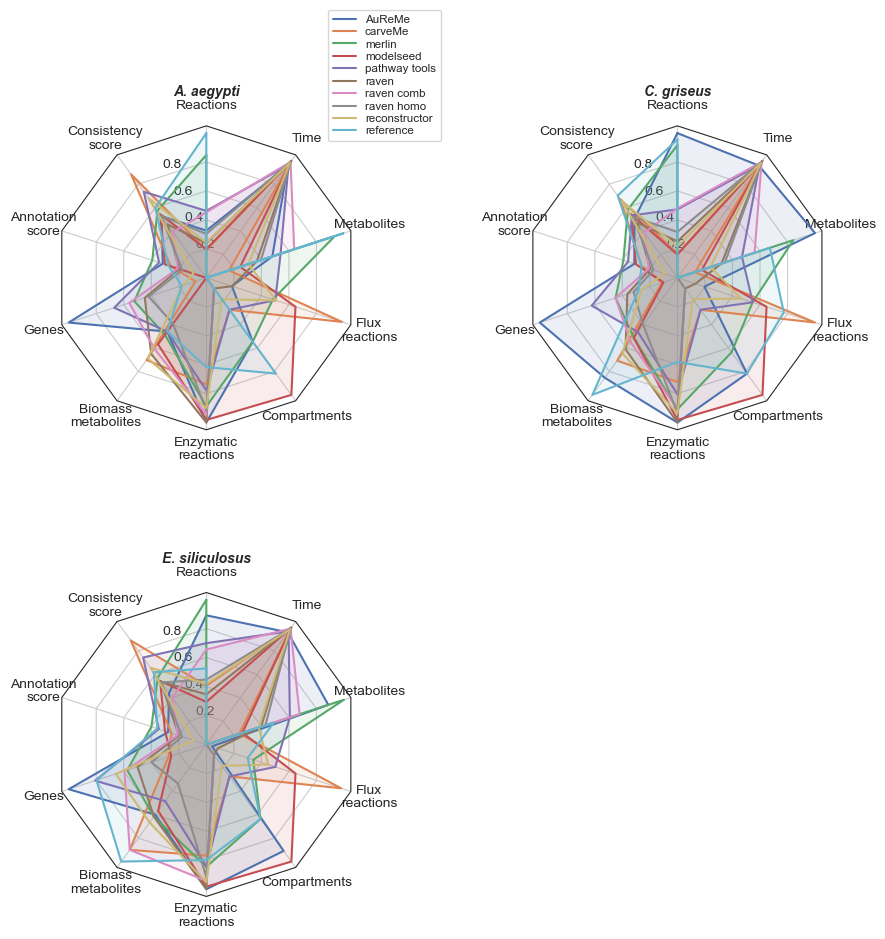

In [5]:
if __name__ == '__main__':
    data = data_plot
    spoke_labels = data.pop(0)
    
    N =len(spoke_labels)
    theta = radar_factory(N, frame='polygon')


    fig, axs = plt.subplots(figsize=(10, 10), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.55, hspace=0.4, top=0.85, bottom=0.05)

    #colors = ['b', 'r', 'g', 'm', 'y'] #colors for different datasets
    colors = sns.color_palette("deep", len(mega_df.columns))
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        if not title =='M_pyrifera':
            ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
            ax.set_title(title.replace('_', '. ').replace('CHO', 'C. griseus'), weight='bold',style='italic', size='medium', position=(0.5, 1.1),
                         horizontalalignment='center', verticalalignment='center')
            for d, color in zip(case_data, colors):
                ax.plot(theta, d, color=color)
                ax.fill(theta, d, facecolor=color, alpha=0.1, label='_nolegend_') 
            ax.set_varlabels(spoke_labels)
    axs[1, 1].axis('off')
    # add legend relative to top-left plot
    to_plot_labels = [m.replace('_',' ') for m in mega_df.columns]
    labels = (to_plot_labels) #mega_df.columns
    legend = axs[0, 0].legend(labels, loc=(0.9, 0.95),
                              labelspacing=0.2, fontsize='small')
    #plt.savefig('test_methods.pdf')
    #plt.savefig('metacyc_methods.png', dpi=300)
    #plt.savefig('modelseed_methods.png', dpi=300)
    #plt.savefig('bigg_methods.png', dpi=300)
    #plt.savefig('kegg_methods.png', dpi=300)
    #plt.savefig('raven_methods.png', dpi=300) 
    #plt.savefig('fig1_withref.png', dpi=300) 
    plt.savefig('fig1_withref_redalpha.png', dpi=300) 
    plt.show()

Compute metrics to be stored in table for supplementary data

In [8]:
#Generate organized by org
new_df_dict = dict()
orgs = ['A_aegypti', 'CHO', 'E_siliculosus']
#org='A_aegypti'
#org='CHO'
#org='E_siliculosus'
#org=  'M_pyrifera'
for org in orgs:
    for c in mega_df.columns:
        print(c)
        print(mega_df[c][org])
        new_df_dict['organism'] = org.replace('_', '. ')
        new_df_dict[c] = mega_df[c][org]
    
    new_df = pd.DataFrame.from_dict(new_df_dict)
    new_df.dropna(axis=1)

    new_df
    new_df.to_csv(org+'.csv')


AuReMe
{'reactions': 1851, 'genes': 8229, 'enzymatic_rxns': 1851, 'flux_rxns': 0.18638573743922204, 'unique_metabolites': 0.986922406277245, 'metabolites': 2294, 'compartments': 6, 'pure_met_rxns': 1832, 'score': 0.39551777515555686, 'cons_score': 0.5269196770402942, 'ann_score': 0.3166766340247144, 'time': 0.9583333333333334, 'biomass': 0.4594594594594595}
carveMe
{'reactions': 1087, 'genes': 649, 'enzymatic_rxns': 800, 'flux_rxns': 0.985280588776449, 'unique_metabolites': 0.7556962025316456, 'metabolites': 790, 'compartments': 3, 'pure_met_rxns': 726, 'score': 0.49398516681258225, 'cons_score': 0.8849529291036452, 'ann_score': 0.2594045094379446, 'time': 0.9993333333333333, 'biomass': 0.7027027027027027}
merlin
{'reactions': 4820, 'genes': 4306, 'enzymatic_rxns': 4284, 'flux_rxns': 0.4831950207468879, 'unique_metabolites': 0.46484549932825797, 'metabolites': 4466, 'compartments': 6, 'pure_met_rxns': 3063, 'score': 0.4609600431571145, 'cons_score': 0.5748076290619406, 'ann_score': 0.3

In [9]:
new_df = pd.DataFrame.from_dict(new_df_dict)
new_df.dropna(axis=1)
#print(method)
print(org)
new_df

E_siliculosus


,organism,AuReMe,carveMe,merlin,pathway_tools,raven,raven_comb,reconstructor,reference
reactions,E. siliculosus,3403.000000,1548.000000,3813.000000,2669.000000,1322.000000,2503.000000,1601.000000,2005.000000
genes,E. siliculosus,2857.000000,786.000000,1642.000000,2309.000000,1428.000000,1700.000000,1879.000000,2281.000000
enzymatic_rxns,E. siliculosus,3403.000000,1189.000000,3224.000000,2250.000000,1322.000000,2360.000000,1523.000000,1601.000000
flux_rxns,E. siliculosus,0.041140,0.979974,0.341201,0.500937,0.084720,0.000000,0.450344,0.300748
unique_metabolites,E. siliculosus,0.863351,0.758333,0.457925,0.951577,1.000000,1.000000,0.979556,0.966455
metabolites,E. siliculosus,3981.000000,1080.000000,4492.000000,2726.000000,1789.000000,3043.000000,1712.000000,2206.000000
compartments,E. siliculosus,10.000000,3.000000,7.000000,3.000000,1.000000,1.000000,2.000000,7.000000
pure_met_rxns,E. siliculosus,3286.000000,1093.000000,3263.000000,2611.000000,1313.000000,2494.000000,1524.000000,1899.000000
score,E. siliculosus,0.338116,0.491523,0.463378,0.494365,0.325833,0.279796,0.303891,0.453927
cons_score,E. siliculosus,0.438698,0.889161,0.570934,0.742823,0.536670,0.400241,0.654901,0.617486


In [22]:
#Generate based on method
new_df_dict = dict()
#methods_to_plot = ['carveMe', 'merlin', 'modelseed', 'raven_homo',
#       'reconstructor', 'raven', 'AuReMe', 'raven_comb', 'pathway_tools']
#method = 'carveMe'
#method = 'merlin'
#method = 'modelseed'
#method = 'raven_homo'
#method = 'reconstructor'
#method = 'raven'
method = 'AuReMe'
#method = 'raven_comb'
#method = 'pathway_tools'
for org in mega_df.index:
    new_df_dict[org] = mega_df[method][org]
    new_df_dict['method'] = method

In [24]:
new_df = pd.DataFrame.from_dict(new_df_dict)
new_df.dropna(axis=1)
print(method)
#print(org)
new_df

AuReMe


,A_aegypti,method,CHO,E_siliculosus,M_pyrifera
reactions,1851.000000,AuReMe,6968.000000,3403.000000,3656.000000
genes,8229.000000,AuReMe,6249.000000,2857.000000,6734.000000
enzymatic_rxns,1851.000000,AuReMe,6968.000000,3403.000000,3656.000000
flux_rxns,0.186386,AuReMe,0.196470,0.041140,0.245350
unique_metabolites,0.986922,AuReMe,0.731634,0.863351,0.936955
metabolites,2294.000000,AuReMe,6629.000000,3981.000000,4013.000000
compartments,6.000000,AuReMe,9.000000,10.000000,14.000000
pure_met_rxns,1832.000000,AuReMe,5094.000000,3286.000000,3585.000000
score,0.395518,AuReMe,0.384808,0.338116,0.363488
cons_score,0.526920,AuReMe,0.504626,0.438698,0.498972


## Figure 2 and S4: Biomass composition of obtained draft models
The objective is to determine the presence and producibility of biomass metabolites from reference models in the draft models. To accomplish this, we create a matrix where each row accounts for a draft model, and each column represents the classification of the metabolites. The radius for each circle, ranging from 0 to 1, represents the presence of the metabolite in the draft model, and the color indicates their producibility.

In [9]:
# Load reference classified biomass metabolites for each organism
file = open("met_ref_class.json")
met_ref = json.load(file)

# Load classified biomass metabolites for the draft models 
file = open("met_draft_class.json")
met_draft = json.load(file)

# Create a dictionary for the reference biomass with the number of metabolites for each category
met_ref_class = {}
super_classes = ["Organic acids", "Nucleic acids", "Lipids", "Inorganic compounds", "Carbohydrates"]

# In case we tried with main classes, (it's not automatized)
# main_classes = ["Inorganic compounds", "Nucleotides", "Amino acids and peptides", "Carboxilic acids", 
#                  "Monosaccharides", "Phospholipids", "Polysaccharide", "Sterols lipids", "Glycerolipids"]


for org, mets in met_ref.items():
    met_class_num = {super_class: 0 for super_class in super_classes}
    for met in mets:
        met_class = met.get("Super class") # There are three classifications: Super class,
                                           # Main class and Sub class, we choose the first one
        if met_class not in met_class_num:
            met_class_num[met_class] = 0
        met_class_num[met_class] += 1
    met_ref_class[org] = met_class_num

In [10]:
met_ref_class

{'A_aegypti': {'Organic acids': 20,
  'Nucleic acids': 8,
  'Lipids': 6,
  'Inorganic compounds': 1,
  'Carbohydrates': 1},
 'CHO': {'Organic acids': 20,
  'Nucleic acids': 8,
  'Lipids': 11,
  'Inorganic compounds': 1,
  'Carbohydrates': 1},
 'E_siliculosus': {'Organic acids': 26,
  'Nucleic acids': 0,
  'Lipids': 0,
  'Inorganic compounds': 0,
  'Carbohydrates': 4},
 'M_pyrifera': {'Organic acids': 26,
  'Nucleic acids': 0,
  'Lipids': 0,
  'Inorganic compounds': 0,
  'Carbohydrates': 4}}

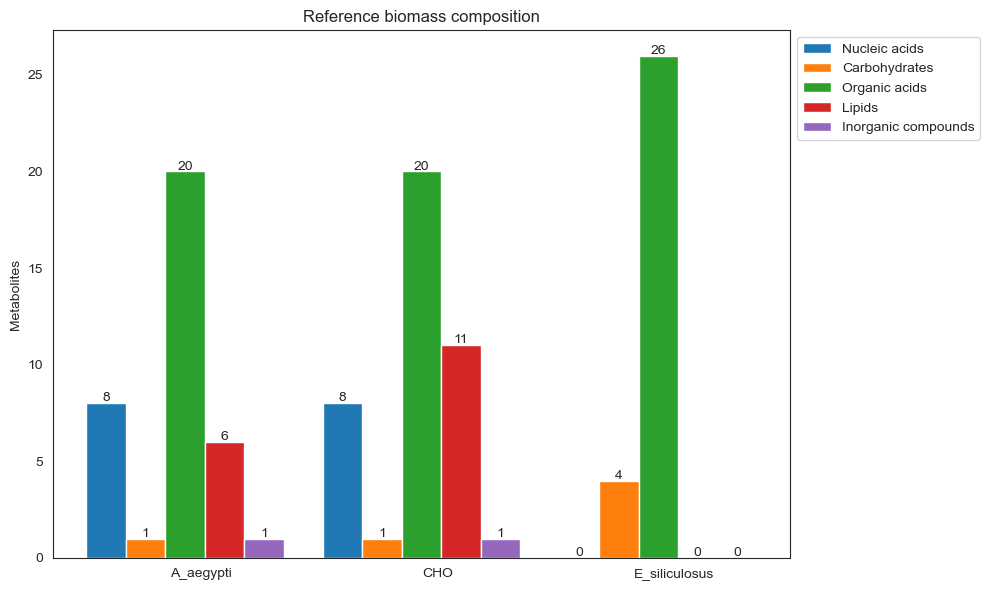

In [11]:
# Biomass reference composition: The plot
plt.rcParams.update({'font.size': 10})
# Skip M. pyrifera
if 'M_pyrifera' in met_ref_class:
    del met_ref_class['M_pyrifera']
    
# Save metabolites classifications
organisms = list(met_ref_class.keys())
metabolites = list(set(met for org in met_ref_class.values() for met in org.keys()))
metabolite_num = {met: [org.get(met, 0) for org in met_ref_class.values()] for met in metabolites}

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
bar_padding = 0
index = range(len(organisms))

for i, (metabolite, counts) in enumerate(metabolite_num.items()):
    ax.bar([x + bar_width * i/1.2  for x in index], counts, bar_width/1.2, label=metabolite)
    for j, count in enumerate(counts):
        ax.text(j + bar_width * i/1.2, count + 0.1, str(count), ha='center')


ax.set_ylabel('Metabolites')
ax.set_title('Reference biomass composition')
ax.set_xticks([x + bar_width * (len(metabolites) - 1) / 2 for x in index])
ax.set_xticklabels(organisms)
ax.legend(loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout()
#plt.savefig('biomass_composition.png', dpi=300)
plt.show()


In [12]:
# Generate two dictionaries:
# 1. Gives the number of metabolites producible, non-producible and absent for each category
# 2. Gives the number of prod and (prod + noprod) metabolites divided by the total metabolites
# for that category

met_counts = {} # dictionary for metabolite classification present in the drafts
all_classif = ["producible", "non-producible", "absent"]

for tool, tool_data in met_draft.items():
    for org, classifs in tool_data.items():
        # Create dictionary with every class
        for classif in all_classif:
            for super_class in {met.get("Super class") for classif, mets in classifs.items() for met in mets}:
                met_counts.setdefault(tool, {}).setdefault(org, {}).setdefault(super_class, {}).setdefault(classif, 0)
        # Count metabolites in each super class and biomass classification (absent, prod, no prod)
        for classif, mets in classifs.items():
            for met in mets:
                super_class = met.get("Super class")
                met_counts.setdefault(tool, {}).setdefault(org, {}).setdefault(super_class, {}).setdefault(classif, 0)
                met_counts[tool][org][super_class][classif] += 1
                    
# 2. We want the prod and (prod + no prod) normalized by the number of metabolites from the reference,
# first one for the producibility (map color) and the second one for the metabolite presence (circle radius)
norm_met_counts = {}

for tool, org_data in met_counts.items():
    if "modelseed" not in tool: # Skip modelseed
        for org, super_class_data in org_data.items():
            if "M_pyrifera" not in org: # Skip M. pyrifera
                for super_class, classif_data in super_class_data.items():
                    total_mets = met_ref_class[org].get(super_class, 1)
                    nonprod_count = classif_data.get("non-producible", 1)
                    prod_count = classif_data.get("producible", 1)
                    prod_proportion = prod_count / total_mets
                    prod_nonprod_sum = (prod_count + nonprod_count) / total_mets

                    norm_met_counts.setdefault(tool, {}).setdefault(org, {}).setdefault(super_class, {})["prod"] = prod_proportion
                    norm_met_counts[tool][org][super_class]["prod_nonprod"] = prod_nonprod_sum

In [20]:
norm_met_counts['carveMe']

{'A_aegypti': {'Nucleic acids': {'prod': 0.5, 'prod_nonprod': 0.5},
  'Carbohydrates': {'prod': 1.0, 'prod_nonprod': 1.0},
  'Organic acids': {'prod': 1.0, 'prod_nonprod': 1.0},
  'Lipids': {'prod': 0.0, 'prod_nonprod': 0.0},
  'Inorganic compounds': {'prod': 1.0, 'prod_nonprod': 1.0}},
 'CHO': {'Nucleic acids': {'prod': 1.0, 'prod_nonprod': 1.0},
  'Carbohydrates': {'prod': 0.0, 'prod_nonprod': 0.0},
  'Organic acids': {'prod': 1.0, 'prod_nonprod': 1.0},
  'Lipids': {'prod': 0.0, 'prod_nonprod': 0.0},
  'Inorganic compounds': {'prod': 1.0, 'prod_nonprod': 1.0}},
 'E_siliculosus': {'Carbohydrates': {'prod': 0.75, 'prod_nonprod': 0.75},
  'Organic acids': {'prod': 0.9230769230769231,
   'prod_nonprod': 0.9230769230769231}}}

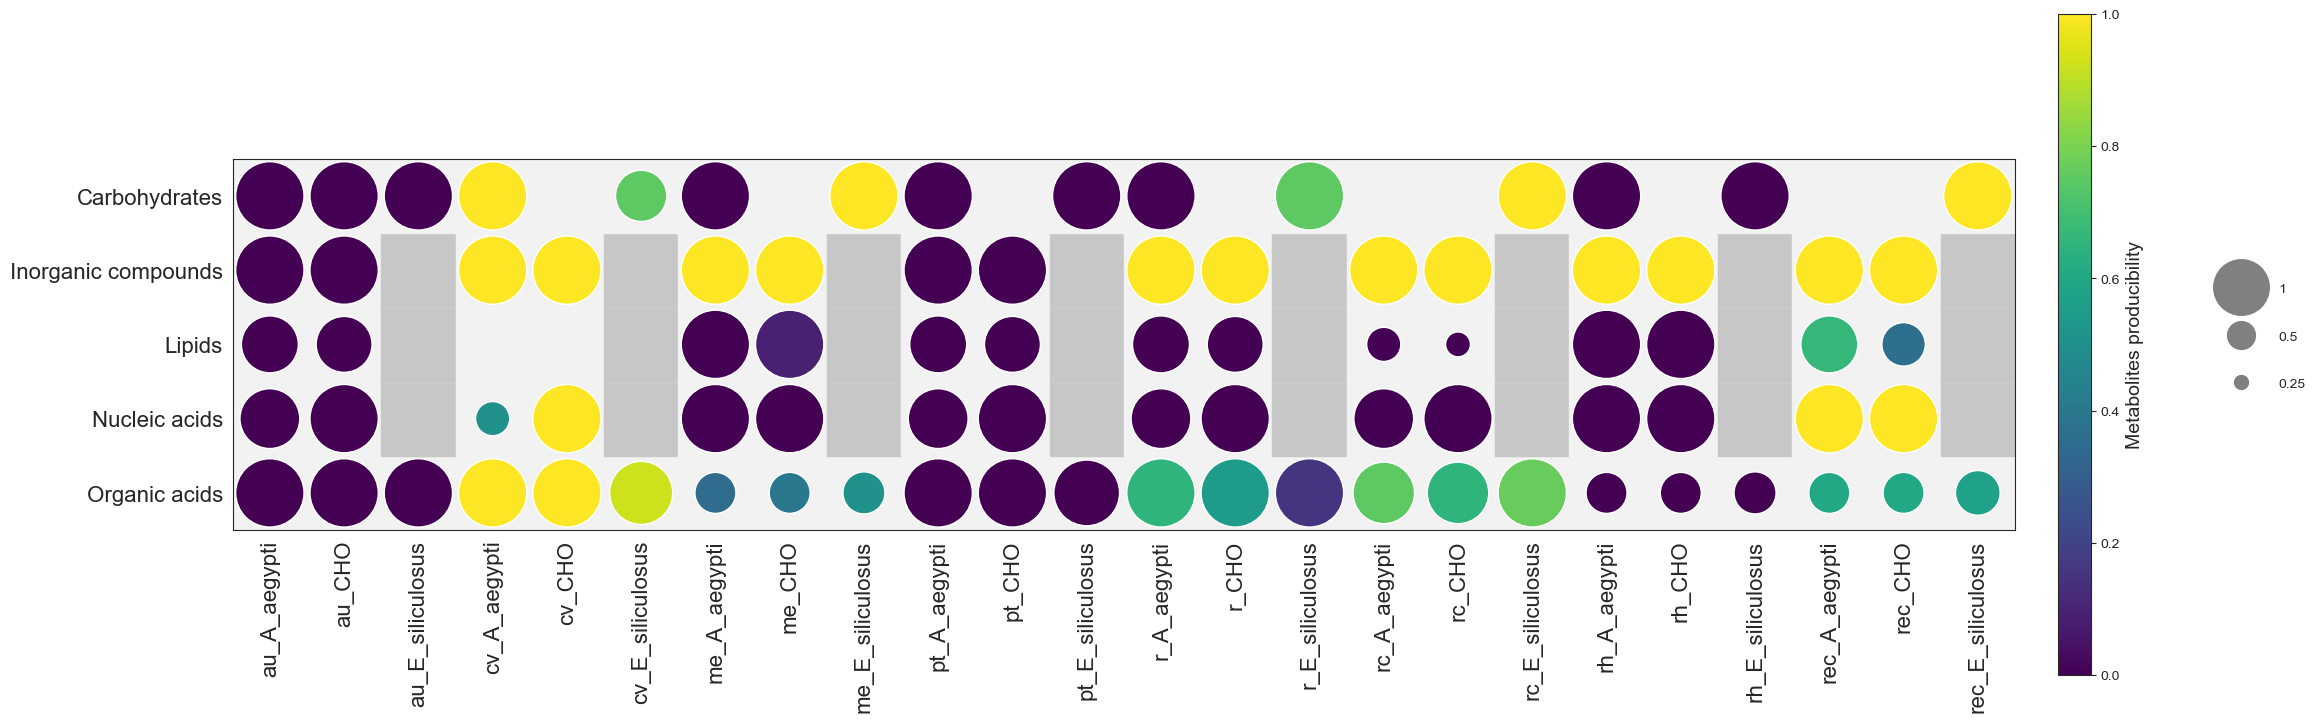

In [19]:
# ###################### Plot #################################################
prefix = {'modelseed': 'ms_', 'reconstructor': 'rec_', 'raven': 'r_', 'raven_homo': 'rh_',
          'raven_comb': 'rc_', 'pathway_tools': 'pt_', 'merlin': 'me_', 'carveMe': 'cv_', 'AuReMe': 'au_' }

x_label = []
y_label = []

for tool, org_data in norm_met_counts.items():
    for org, super_class_data in org_data.items():
        x_label.append(prefix[tool] + org)

for super_class in super_classes:
    y_label.append(super_class) 
    
x, y = np.meshgrid(np.arange(len(x_label)), np.arange(len(y_label)))

producibility_values = []
presence_values = []

# Save values for the colormap and radius
for tool, org_data in norm_met_counts.items():
    for org, super_class_data in org_data.items():
        for super_class in super_classes:
            prod_value = super_class_data.get(super_class, {}).get('prod', 0)
            prod_noprod_value = super_class_data.get(super_class, {}).get('prod_nonprod', 0)
            producibility_values.append(prod_value)
            presence_values.append(prod_noprod_value)
            
presence_values = np.array(presence_values).reshape((24, 5))

producibility = np.array(producibility_values)
presence = presence_values

fig_size = (len(x_label), len(y_label)*1.5)
fig, ax = plt.subplots(figsize=fig_size)


# Create circles regarding the metabolites "prod" or "no-prod"
circles = []

for i in range(len(x_label)):
    for j in range(len(y_label)):
        rect = Rectangle((i-0.5, j-0.5), 1, 1, color=(0.95, 0.95, 0.95))  # Light grey
        ax.add_patch(rect)
    
        radius = 0.46 * presence[i, j] # 0.46 to adjust the size
        circle = Circle((i, j), radius = radius, edgecolor=None)
        circles.append(circle)
        
        if (i % 3 in [2]) and (j in [1, 2, 3]): # Metabolites classifications absent in E. siliculosus
            rect = Rectangle((i-0.5, j-0.5), 1, 1, color=(0.78, 0.78, 0.78)) # Grey
            ax.add_patch(rect)
        

cmap = plt.get_cmap('viridis')
col = PatchCollection(circles, cmap="viridis")
col.set_array(producibility.flatten()) 

ax.add_collection(col)
ax.set(xticks=np.arange(len(x_label)), yticks=np.arange(len(y_label)),
        xticklabels=x_label, yticklabels=y_label)
ax.set_xticklabels(x_label, rotation=90)
ax.set_xticks(np.arange(len(x_label)+1)-0.5, minor=True)
ax.set_yticks(np.arange(len(y_label)+1)-0.5, minor=True)
ax.tick_params(axis='both',labelsize=16)
ax.grid(which='minor')
ax.set_aspect("equal", "box")

cbar = fig.colorbar(col, ax=ax, pad=0.02)
cbar.set_label('Metabolites producibility', fontsize=14)

# AaaAAAa
s1 = Line2D([0], [0], marker='o', markersize=40, color='grey', linestyle='None')
s2 = Line2D([0], [0], marker='o', markersize=20, color='grey', linestyle='None')
s3 = Line2D([0], [0], marker='o', markersize=10, color='grey', linestyle='None')
spacing = 2.5

plt.legend([s1, s2, s3], ['1', '0.5', '0.25'], bbox_to_anchor=(1.17, 0.7), frameon=False, labelspacing=spacing, handletextpad=1.7)
plt.tight_layout()
plt.savefig('biomass_analysis.png', dpi=300)


plt.show()

## Figure 3: Compartment analysis

In [58]:
# Importing necessary libraries
import re

# File path for the SBML file
def compartment_analysis(archivo_sbml):
    # Reading the SBML model using the cobra library
    modelo = cobra.io.read_sbml_model(archivo_sbml)

    # Initializing an empty list to store reaction data
    datos_reacciones = []
    # Regular expression pattern to match 'or' and 'and' with surrounding spaces
    pattern = re.compile(r'\s+or\s+|\s+and\s+')
    # Iterating over each reaction in the model
    for reaccion in modelo.reactions:
        # Extracting reactants, products, and gene-protein-reaction (GPR) rule information
        reactantes = [metabolito.id for metabolito in reaccion.reactants]
        productos = [metabolito.id for metabolito in reaccion.products]
        gpr = reaccion.gene_reaction_rule
    
        # Processing reactants and products to remove suffixes
        reactantes_filt = [metabolito.rsplit('_', 1)[0] for metabolito in reactantes]
        productos_filt = [metabolito.rsplit('_', 1)[0] for metabolito in productos]
        comp_list = list()
        for nc in reactantes_filt:
            for wc in reactantes:
                if wc.startswith(nc):
                    comp = wc.replace(nc,'')
                    comp = comp.replace('_','')
                    comp_list.append(comp)
        for nc in productos_filt:
            for wc in productos:
                if wc.startswith(nc):
                    comp = wc.replace(nc,'')
                    comp = comp.replace('_','')
                    comp_list.append(comp)
    
        comp_list = list(set(comp_list))
        if len(comp_list)>1:
            comp_list = 'transport'
        elif len(comp_list)>0:
            comp_list = comp_list[0]
        # Splitting the GPR rule into elements and cleaning up the formatting
        gpr_elements = [element.replace('(', '').replace(')', '').replace(' ', '') for element in re.split(pattern, gpr)]
        
        
        # Appending the processed data to the list
        datos_reacciones.append([reaccion.id, reactantes, productos, gpr, reactantes_filt, productos_filt, gpr_elements, comp_list])
        
    
    # Defining column names for the DataFrame
    columnas = ['ID', 'Reactants', 'Products', 'GPR', 'Reactants_filt', 'Products_filt', 'gpr_elements', 'Compartment']
    
    # Creating a DataFrame from the list of reaction data
    df_reacciones = pd.DataFrame(datos_reacciones, columns=columnas)
    
    # Creating additional columns with sorted tuples for comparison
    df_reacciones['Reactants_tuple_sorted'] = df_reacciones['Reactants_filt'].apply(lambda x: tuple(sorted(x)))
    df_reacciones['Products_tuple_sorted'] = df_reacciones['Products_filt'].apply(lambda x: tuple(sorted(x)))
    df_reacciones['gpr_elements_tuple_sorted'] = df_reacciones['gpr_elements'].apply(lambda x: tuple(sorted(x)))
    
    # Identifying reactions with duplicate reactants and products
    df_duplicados = df_reacciones[df_reacciones.duplicated(subset=['Reactants_tuple_sorted', 'Products_tuple_sorted'], keep=False)]
    
    # Identifying reactions with the same GPR rule and duplicate reactants/products
    df_duplicados_2 = df_reacciones[df_reacciones.duplicated(subset=['gpr_elements_tuple_sorted', 'Reactants_tuple_sorted', 'Products_tuple_sorted'], keep=False)]
    
    # Merging the two duplicate DataFrames and indicating the source of each row
    merged_df = pd.merge(df_duplicados, df_duplicados_2, on='ID', how='outer', indicator=True)
    
    # Extracting rows that are only present in the left DataFrame (differences in GPR rules)
    diferencia_df = merged_df[merged_df['_merge'] == 'left_only']
    
    # Selecting relevant columns for the final result
    df_resultado_final = diferencia_df.iloc[:, :10] #Why?
    
    # Filtering out rows where the GPR rule is an empty string
    df_resultado_final = df_resultado_final[df_resultado_final['GPR_x'].astype(str).str.strip() != '']
    
    # Filtering out rows with the same GPR rule in the second set of duplicates
    df_duplicados_2 = df_duplicados_2[df_duplicados_2['GPR'].astype(str).str.strip() != '']
    result = dict()
    # Printing the number of reactions with different GPR rules among duplicates
    num_filas_resultado_final = df_resultado_final.shape[0]
    print("Duplicated reactions different GPR: ", num_filas_resultado_final)
    result['Duplicated reactions different GPR'] = num_filas_resultado_final
    # Printing the number of reactions with the same GPR rule among duplicates
    num_filas_duplicados_2 = df_duplicados_2.shape[0]
    
    print("Duplicated reactions same GPR:", num_filas_duplicados_2)
    result['Duplicated reactions same GPR'] = num_filas_duplicados_2
    # Printing the total number of reactions with duplicates
    num_filas_duplicados = df_duplicados.shape[0]
    print("Duplicated reactions:", num_filas_duplicados)
    result['Duplicated reactions'] = num_filas_duplicados
    # Filtering out rows without a GPR rule in the first set of duplicates
    df_duplicados = df_duplicados[df_duplicados['GPR'].astype(str).str.strip() != '']
    
    # Printing the total number of reactions with duplicates and a GPR rule
    num_filas_duplicados = df_duplicados.shape[0]
    print("Duplicated reactions with GPR:", num_filas_duplicados)
    result['Duplicated reactions with GPR'] = num_filas_duplicados
    dfs = [df_duplicados, df_duplicados_2] #df_duplicados: reactions different GPR among duplicates, df_duplicados2: same GPR rule
    return result, dfs

In [64]:
res, dfs = compartment_analysis('./to_plot/reference/CHO.xml')

Duplicated reactions different GPR:  778
Duplicated reactions same GPR: 533
Duplicated reactions: 2481
Duplicated reactions with GPR: 1311


In [65]:
dfs[1] #Reactions same GPR different compartments

,ID,Reactants,Products,GPR,Reactants_filt,Products_filt,gpr_elements,Compartment,Reactants_tuple_sorted,Products_tuple_sorted,gpr_elements_tuple_sorted
81,AASAD3,"[L2aadp6sa_c, h2o_c, nad_c]","[L2aadp_c, h_c, nadh_c]",100756509,"[L2aadp6sa, h2o, nad]","[L2aadp, h, nadh]",[100756509],c,"(L2aadp6sa, h2o, nad)","(L2aadp, h, nadh)","(100756509,)"
83,AASAD3m,"[L2aadp6sa_m, h2o_m, nad_m]","[L2aadp_m, h_m, nadh_m]",100756509,"[L2aadp6sa, h2o, nad]","[L2aadp, h, nadh]",[100756509],m,"(L2aadp6sa, h2o, nad)","(L2aadp, h, nadh)","(100756509,)"
120,ABUTt2r,"[4abut_e, h_e]","[4abut_c, h_c]",100765800 or 100766093,"[4abut, h]","[4abut, h]","[100765800, 100766093]",transport,"(4abut, h)","(4abut, h)","(100765800, 100766093)"
121,ABUTt2rL,"[4abut_l, h_l]","[4abut_c, h_c]",100765800 or 100766093,"[4abut, h]","[4abut, h]","[100765800, 100766093]",transport,"(4abut, h)","(4abut, h)","(100765800, 100766093)"
181,ACCOAgt,[accoa_c],[accoa_g],100756415,[accoa],[accoa],[100756415],transport,"(accoa,)","(accoa,)","(100756415,)"
...,...,...,...,...,...,...,...,...,...,...,...
6514,r1706,"[gln__L_e, na1_e, trp__L_c]","[gln__L_c, na1_c, trp__L_e]",100760403 and 100689315,"[gln__L, na1, trp__L]","[gln__L, na1, trp__L]","[100760403, 100689315]",transport,"(gln__L, na1, trp__L)","(gln__L, na1, trp__L)","(100689315, 100760403)"
6539,r1707,"[gln__L_e, na1_e, phe__L_c]","[gln__L_c, na1_c, phe__L_e]",100760403 and 100689315,"[gln__L, na1, phe__L]","[gln__L, na1, phe__L]","[100760403, 100689315]",transport,"(gln__L, na1, phe__L)","(gln__L, na1, phe__L)","(100689315, 100760403)"
6545,r1708,"[gln__L_e, na1_e, tyr__L_c]","[gln__L_c, na1_c, tyr__L_e]",100760403 and 100689315,"[gln__L, na1, tyr__L]","[gln__L, na1, tyr__L]","[100760403, 100689315]",transport,"(gln__L, na1, tyr__L)","(gln__L, na1, tyr__L)","(100689315, 100760403)"
6555,r1710,"[gln__L_e, leu__L_c, na1_e]","[gln__L_c, leu__L_e, na1_c]",100760403 and 100689315,"[gln__L, leu__L, na1]","[gln__L, leu__L, na1]","[100760403, 100689315]",transport,"(gln__L, leu__L, na1)","(gln__L, leu__L, na1)","(100689315, 100760403)"


In [66]:
dfs[1].groupby(['Compartment'], as_index=False).count()

,Compartment,ID,Reactants,Products,GPR,Reactants_filt,Products_filt,gpr_elements,Reactants_tuple_sorted,Products_tuple_sorted,gpr_elements_tuple_sorted
0,c,96,96,96,96,96,96,96,96,96,96
1,e,13,13,13,13,13,13,13,13,13,13
2,g,8,8,8,8,8,8,8,8,8,8
3,l,10,10,10,10,10,10,10,10,10,10
4,m,41,41,41,41,41,41,41,41,41,41
5,n,39,39,39,39,39,39,39,39,39,39
6,r,21,21,21,21,21,21,21,21,21,21
7,transport,278,278,278,278,278,278,278,278,278,278
8,x,27,27,27,27,27,27,27,27,27,27


In [67]:
dfs[0]

,ID,Reactants,Products,GPR,Reactants_filt,Products_filt,gpr_elements,Compartment,Reactants_tuple_sorted,Products_tuple_sorted,gpr_elements_tuple_sorted
1,24_25VITD3Hm,"[25hvitd3_m, h_m, nadph_m, o2_m]","[2425dhvitd3_m, h2o_m, nadp_m]",100751280 and 100751853 and 100773278,"[25hvitd3, h, nadph, o2]","[2425dhvitd3, h2o, nadp]","[100751280, 100751853, 100773278]",m,"(25hvitd3, h, nadph, o2)","(2425dhvitd3, h2o, nadp)","(100751280, 100751853, 100773278)"
8,25VITD3Hm,"[25hvitd3_m, h_m, nadph_m, o2_m]","[1a25dhvitd3_m, h2o_m, nadp_m]",100760414 and 100751853 and 100773278,"[25hvitd3, h, nadph, o2]","[1a25dhvitd3, h2o, nadp]","[100760414, 100751853, 100773278]",m,"(25hvitd3, h, nadph, o2)","(1a25dhvitd3, h2o, nadp)","(100751853, 100760414, 100773278)"
35,3SALATAi,"[3sala_c, akg_c, h_c]","[3snpyr_c, glu__L_c]",100762297,"[3sala, akg, h]","[3snpyr, glu__L]",[100762297],c,"(3sala, akg, h)","(3snpyr, glu__L)","(100762297,)"
36,3SALATAim,"[3sala_m, akg_m, h_m]","[3snpyr_m, glu__L_m]",100762838,"[3sala, akg, h]","[3snpyr, glu__L]",[100762838],m,"(3sala, akg, h)","(3snpyr, glu__L)","(100762838,)"
40,2HCO3_NAt,"[hco3_e, na1_e]","[hco3_c, na1_c]",100763623 or 100771517,"[hco3, na1]","[hco3, na1]","[100763623, 100771517]",transport,"(hco3, na1)","(hco3, na1)","(100763623, 100771517)"
...,...,...,...,...,...,...,...,...,...,...,...
6545,r1708,"[gln__L_e, na1_e, tyr__L_c]","[gln__L_c, na1_c, tyr__L_e]",100760403 and 100689315,"[gln__L, na1, tyr__L]","[gln__L, na1, tyr__L]","[100760403, 100689315]",transport,"(gln__L, na1, tyr__L)","(gln__L, na1, tyr__L)","(100689315, 100760403)"
6555,r1710,"[gln__L_e, leu__L_c, na1_e]","[gln__L_c, leu__L_e, na1_c]",100760403 and 100689315,"[gln__L, leu__L, na1]","[gln__L, leu__L, na1]","[100760403, 100689315]",transport,"(gln__L, leu__L, na1)","(gln__L, leu__L, na1)","(100689315, 100760403)"
6571,r1711,"[gln__L_e, na1_e, pro__L_c]","[gln__L_c, na1_c, pro__L_e]",100760403 and 100689315,"[gln__L, na1, pro__L]","[gln__L, na1, pro__L]","[100760403, 100689315]",transport,"(gln__L, na1, pro__L)","(gln__L, na1, pro__L)","(100689315, 100760403)"
6658,r2404,"[arg__L_c, h_c, orn_m]","[arg__L_m, h_m, orn_c]",100773024 or 100758204,"[arg__L, h, orn]","[arg__L, h, orn]","[100773024, 100758204]",transport,"(arg__L, h, orn)","(arg__L, h, orn)","(100758204, 100773024)"


In [68]:
dfs[0].groupby(['gpr_elements_tuple_sorted'], as_index=False).count()

,gpr_elements_tuple_sorted,ID,Reactants,Products,GPR,Reactants_filt,Products_filt,gpr_elements,Compartment,Reactants_tuple_sorted,Products_tuple_sorted
0,"(100682535,)",1,1,1,1,1,1,1,1,1,1
1,"(100689019, 100689020, 100752270, 103163344)",7,7,7,7,7,7,7,7,7,7
2,"(100689022,)",18,18,18,18,18,18,18,18,18,18
3,"(100689023, 100689024)",1,1,1,1,1,1,1,1,1,1
4,"(100689023, 100689025, 100773189)",1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
468,"(100774867,)",1,1,1,1,1,1,1,1,1,1
469,"(100775004,)",10,10,10,10,10,10,10,10,10,10
470,"(103158535,)",2,2,2,2,2,2,2,2,2,2
471,"(103160971,)",2,2,2,2,2,2,2,2,2,2


In [69]:
genes = set()
for gpr in dfs[0]['gpr_elements_tuple_sorted']:
    for g in gpr:
        genes.add(g)

In [70]:
len(genes) #genes associated with different gene associations

705

In [82]:
file_path = 'compartment_analysis.csv'
comp_df = pd.read_csv(file_path, sep=';')

In [83]:
comp_df

,'Tool/File',model,Tool,Organism,Duplicated reactions different GPR,Duplicated reactions same GPR,Duplicated reactions no GPR
0,'Aureme\Aedes_Aureme.sbml',au_A_aegypti,AuReMe,A_aegypti,46,14,0
1,'Aureme\CHO_Aureme.sbml',au_CHO,AuReMe,CHO,637,637,0
2,'Aureme\CHO_Recon.sbml',au_CHO,AuReMe,CHO,631,611,0
3,'Aureme\Ectocarpus_Aureme.sbml',au_E_siliculosus,AuReMe,E_siliculosus,87,289,0
4,'Aureme\Ecto_Saccharina_Aureme.sbml',au_S_japonica,AuReMe,E_siliculosus,229,107,0
5,'Aureme\Mpyr_Aureme.sbml',au_M_pyrifera,AuReMe,M_pyrifera,246,83,0
6,'Aureme\Mpyr_Chlamydomonas.sbml',au_M_pyrifera,AuReMe,M_pyrifera,85,273,0
7,'CarveMe\A_aegypti.xml',cv_A_aegypti,carveMe,A_aegypti,41,12,14
8,'CarveMe\CHO.xml',cv_CHO,carveMe,CHO,43,20,29
9,'CarveMe\E_siliculosus.xml',cv_E_siliculosus,carveMe,E_siliculosus,78,37,26


In [101]:
sns.set_palette("deep")

In [102]:
comp_df.index = comp_df['model']

In [103]:
comp_df = comp_df[comp_df['Organism']!= 'M_pyrifera']
comp_df = comp_df[comp_df['Organism']!= 'S_japonica']

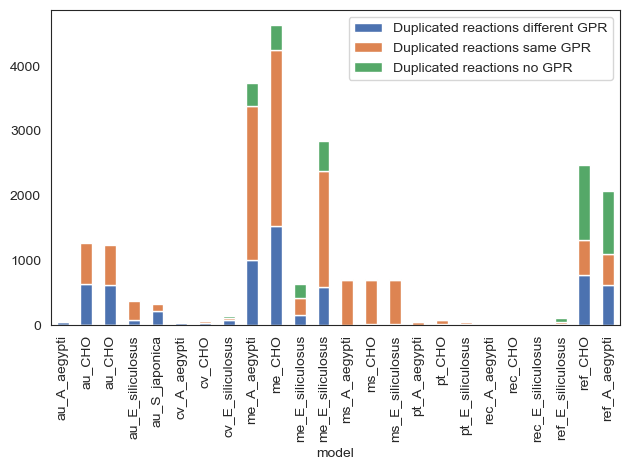

In [109]:
fig = comp_df.plot.bar(stacked=True).figure
fig.tight_layout()
fig.savefig("GPR_all.png", dpi=300) 

In [97]:
comp_df

,'Tool/File',model,Tool,Organism,Duplicated reactions different GPR,Duplicated reactions same GPR,Duplicated reactions no GPR
model,,,,,,,
au_A_aegypti,'Aureme\Aedes_Aureme.sbml',au_A_aegypti,AuReMe,A_aegypti,46,14,0
au_CHO,'Aureme\CHO_Aureme.sbml',au_CHO,AuReMe,CHO,637,637,0
au_CHO,'Aureme\CHO_Recon.sbml',au_CHO,AuReMe,CHO,631,611,0
au_E_siliculosus,'Aureme\Ectocarpus_Aureme.sbml',au_E_siliculosus,AuReMe,E_siliculosus,87,289,0
au_S_japonica,'Aureme\Ecto_Saccharina_Aureme.sbml',au_S_japonica,AuReMe,E_siliculosus,229,107,0
cv_A_aegypti,'CarveMe\A_aegypti.xml',cv_A_aegypti,carveMe,A_aegypti,41,12,14
cv_CHO,'CarveMe\CHO.xml',cv_CHO,carveMe,CHO,43,20,29
cv_E_siliculosus,'CarveMe\E_siliculosus.xml',cv_E_siliculosus,carveMe,E_siliculosus,78,37,26
me_A_aegypti,'Merlin\Aedes_merlin_support.xml',me_A_aegypti,Merlin,A_aegypti,1010,2374,358


In [98]:
#cv, pt, rec and ref / delete aureme, merlin, modelseed

plot_df = comp_df[comp_df['Tool']!= 'AuReMe']
plot_df = plot_df[plot_df['Tool']!= 'Merlin']
plot_df = plot_df[plot_df['Tool']!= 'Modelseed']
plot_df = plot_df[plot_df['model']!= 'ref_CHO']
plot_df = plot_df[plot_df['model']!= 'ref_A_aegypti']

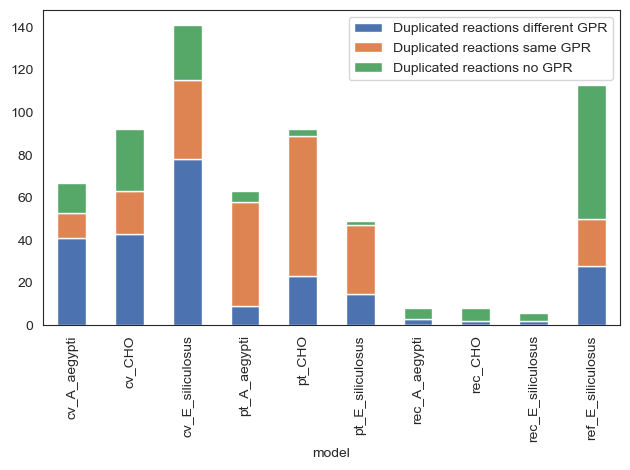

In [110]:
fig = plot_df.plot.bar(stacked=True).figure
fig.tight_layout()
fig.savefig("GPR_small.png", dpi=300) 

## Figure 4: Specialized metabolites

In [88]:
#load files specialized metabolites
name_df = pd.read_csv('./specialized_metabolites/Alga_name_id.txt').dropna()
list_ES = list(name_df['KEGG'].dropna().unique())

In [89]:
k_df = pd.read_csv('./specialized_metabolites/Alga_KEGG_ids.txt')
list_ES.extend(list(k_df['KEGG'].dropna().unique()))
len(k_df['KEGG'].dropna().unique())
list_ES = list(set(list_ES))

In [90]:
#load files specialized metabolites
name_df = pd.read_csv('./specialized_metabolites/Aedes_name_id.txt').dropna()
list_AA = list(name_df['KEGG'].dropna().unique())

In [91]:
#load files specialized metabolites
name_df = pd.read_csv('./specialized_metabolites/CHO_name_id.txt').dropna()
list_CHO = list(name_df['KEGG'].dropna().unique())

In [92]:
kegg_dict = {'A_aegypti': list_AA, 'CHO': list_CHO, 'E_siliculosus': list_ES}

In [96]:
##new kegg_dict selecting only elements that are ONLY in that specific dataset
aedes = set(kegg_dict['A_aegypti']) #I checked and there is no difference 
CHO = set(kegg_dict['CHO'])
ecto = set(kegg_dict['E_siliculosus'])

In [97]:
new_aedes = aedes - CHO - ecto
new_CHO = CHO - aedes - ecto
new_ecto = ecto - aedes - CHO

In [34]:
kegg_dict = {'A_aegypti': list(new_aedes), 'CHO': list(new_CHO), 'E_siliculosus': list(new_ecto)}

In [ ]:
df_KEGG = pd.read_csv('./specialized_metabolites/models_to_KEGG.csv', index_col=0)

In [112]:
df_KEGGref = pd.read_csv('./specialized_metabolites/refs_KEGG.csv', index_col=0)

In [137]:
df_KEGG = pd.concat([df_KEGG, df_KEGGref]).fillna(0)

In [138]:
df_core = df_KEGG[df_KEGG[:].nunique(axis=1) == 1]

In [ ]:
orgs = ['A_aegypti', 'CHO', 'E_siliculosus']
map_dict = dict()
total_dict = dict()
detail_common = dict()
for org in orgs:
    common = list(set(df_KEGG.index).intersection(set(kegg_dict[org]))) #metabolites present in both dataframe models and set to map
    total_dict[org] = len(common)
    map = df_KEGG.loc[common].sum()
    ids_map = dict()
    for col in df_KEGG.columns:
        filter_df = df_KEGG[col]
        filter_df = filter_df.loc[common]
        mapped = filter_df[filter_df>0].index.to_list()
        ids_map[col] = mapped
    map_dict[org] = map.to_dict()
    detail_common[org]  = ids_map

In [140]:
df_KEGG = df_KEGG.reindex(sorted(df_KEGG.columns), axis=1)

In [144]:
re_org_cols = ['au_A_aegypti', 'au_CHO', 'au_E_siliculosus', 'cv_A_aegypti', 'cv_CHO',
       'cv_E_siliculosus', 'me_A_aegypti', 'me_CHO', 'me_E_siliculosus',
       'pt_A_aegypti', 'pt_CHO', 'pt_E_siliculosus', 'r_A_aegypti', 'r_CHO',
       'r_E_siliculosus', 'rc_A_aegypti', 'rc_CHO', 'rc_E_siliculosus',
        'rh_A_aegypti', 'rh_CHO', 'rh_E_siliculosus', 'rec_A_aegypti', 'rec_CHO', 'rec_E_siliculosus', 'ref_A_aegypti',
       'ref_CHO', 'ref_E_siliculosus' ]

In [193]:
df_KEGG = df_KEGG[re_org_cols]

In [197]:
#extended dataframe with structure for seaborn plot, includes core metabolite mapping
orgs = ['A_aegypti', 'CHO', 'E_siliculosus']
prefix_rev = {'ms': 'modelSEED', 'rec': 'reconstructor', 'r': 'raven', 'rh': 'raven homo', 'rc': 'raven comb', 
         'pt': 'pathway tools', 'me': 'merlin', 'cv': 'carveMe', 'au': 'AuReMe', 'ref': 'reference' }
map_dict = dict()
total_dict = dict()
detail_common = dict()
df_dict = dict() #dict with dataframe
index = 0
core_spec = set(kegg_dict['A_aegypti']) & set(kegg_dict['CHO']) & set(kegg_dict['E_siliculosus'])
for org in orgs:
    common = list(set(df_KEGG.index).intersection(set(kegg_dict[org]))) #metabolites present in both dataframe models and set to map
    total_dict[org] = len(common)
    map = df_KEGG.loc[common].sum()
    ids_map = dict()
    for col in df_KEGG.columns:
        row_dict = dict()
        #model, type (total/core), metabolites (number), organism (from which specialized metabolites are mapped)
        filter_df = df_KEGG[col]
        filter_df = filter_df.loc[common]
        mapped = filter_df[filter_df>0].index.to_list()
        ids_map[col] = mapped
        row_dict['model'] = col
        row_dict['Method'] = prefix_rev[col.split('_')[0]]
        xx, modeled_org = col.split('_',1)
        row_dict['Model org'] = modeled_org.replace('_','. ')
        row_dict['type'] = 'total'
        row_dict['metabolites'] = len(mapped)
        row_dict['organism'] = org.replace('CHO','C. griseus').replace('_','. ')
        df_dict[index] = row_dict
        index = index + 1
        
    map_dict[org] = map.to_dict()
    detail_common[org]  = ids_map

In [198]:
df_map_spe_mets = pd.DataFrame.from_dict(df_dict, orient='index')

In [199]:
df_map_spe_mets

,model,Method,Model org,type,metabolites,organism
0,au_A_aegypti,AuReMe,A. aegypti,total,24,A. aegypti
1,au_CHO,AuReMe,CHO,total,33,A. aegypti
2,au_E_siliculosus,AuReMe,E. siliculosus,total,26,A. aegypti
3,cv_A_aegypti,carveMe,A. aegypti,total,20,A. aegypti
4,cv_CHO,carveMe,CHO,total,19,A. aegypti
...,...,...,...,...,...,...
76,rec_CHO,reconstructor,CHO,total,144,E. siliculosus
77,rec_E_siliculosus,reconstructor,E. siliculosus,total,156,E. siliculosus
78,ref_A_aegypti,reference,A. aegypti,total,155,E. siliculosus
79,ref_CHO,reference,CHO,total,159,E. siliculosus


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

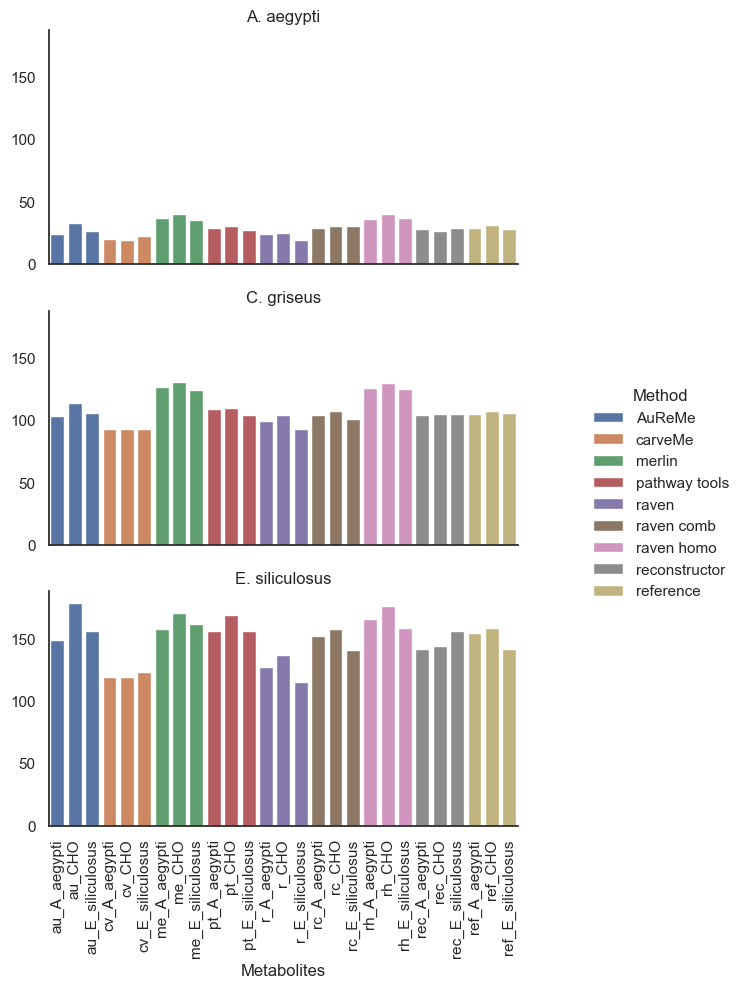

In [215]:

sns.set_theme(style="white", palette="deep")
g = sns.catplot(
    df_map_spe_mets, kind="bar",
    x="model", y="metabolites", hue='Method', row="organism",
    height=3, aspect=2, dodge=False
)
g.set_axis_labels("Metabolites", "")
g.set_titles("{row_name}")
g.tight_layout()
g.tick_params(axis='x', labelrotation=90)
g.savefig("map_specialized.pdf")

In [204]:
df_sub = df_map_spe_mets[df_map_spe_mets['organism']=='A. aegypti']

In [206]:
df_sub.groupby(['Model org'])['metabolites'].std()

Model org
A. aegypti        5.502525
CHO               6.802777
E. siliculosus    5.666667
Name: metabolites, dtype: float64

In [207]:
df_sub.groupby(['Method'])['metabolites'].std()

Method
AuReMe           4.725816
carveMe          1.527525
merlin           2.516611
pathway tools    1.527525
raven            3.214550
raven comb       0.577350
raven homo       2.081666
reconstructor    1.527525
reference        1.527525
Name: metabolites, dtype: float64

In [208]:
df_sub = df_map_spe_mets[df_map_spe_mets['organism']=='C. griseus']

In [209]:
df_sub.groupby(['Model org'])['metabolites'].std()

Model org
A. aegypti        11.497584
CHO               12.306277
E. siliculosus    11.467345
Name: metabolites, dtype: float64

In [210]:
df_sub.groupby(['Method'])['metabolites'].std()

Method
AuReMe           5.686241
carveMe          0.000000
merlin           3.511885
pathway tools    3.214550
raven            5.507571
raven comb       3.000000
raven homo       2.645751
reconstructor    0.577350
reference        1.000000
Name: metabolites, dtype: float64

In [211]:
df_sub = df_map_spe_mets[df_map_spe_mets['organism']=='E. siliculosus']

In [212]:
df_sub.groupby(['Model org'])['metabolites'].std()

Model org
A. aegypti        15.267977
CHO               20.009026
E. siliculosus    16.786238
Name: metabolites, dtype: float64

In [213]:
df_sub.groupby(['Method'])['metabolites'].std()

Method
AuReMe           15.695010
carveMe           2.309401
merlin            6.658328
pathway tools     7.505553
raven            11.015141
raven comb        8.621678
raven homo        8.544004
reconstructor     7.571878
reference         8.888194
Name: metabolites, dtype: float64

## Model dataframe data

Load models and compute a dataframe with their data. I will start with defining just a matrix of metabolites present on each model



In [77]:
import os
import cobra
import logging

logging.getLogger("cobra").setLevel(logging.ERROR)

In [78]:
###Get files to curate mapping manually
mega_dict = dict()
#mega_dict: keys are methods, maps to method_dict
#method_dict: one dictionary for each method, keys are organisms (org_dict)
#org_dict: keys are features of org for that method, example: loaded cobrapy model, metabolite ids

#The idea is that for each method you have access for all the metabolites

methods = ['AuReMe', 'carveMe',
 'merlin',
 'modelseed', 'raven_homo',
 'reconstructor',
 'raven',
 'raven_comb',
 'pathway_tools']

db_dict = {'raven': ['metacyc'], 'raven_homo': ['kegg'], 'raven_comb': ['metacyc', "kegg"] , 'pathway_tools': ['metacyc'],
          'merlin': ['kegg'], 'carveMe': ['bigg'], 'reconstructor': ['modelseed'], 'modelseed': ['modelseed'], 
           "AuReMe": ['metacyc', "bigg", "kegg", "modelseed"]}
for method in methods:
    if not method.startswith('.'):
        method_dict = dict()
        print(method)
        for org in os.listdir('./to_plot/'+method):
            if not org.startswith('.') and not org.endswith('.json') and not org.startswith('~$'):
                org_dict = dict()
                if not org.startswith('M_pyrifera'):
                    print(org)
                    #load model cobrapy
                    sbml_path = './to_plot/'+method+'/'+org
                    model = cobra.io.read_sbml_model(sbml_path) 
                    org_dict['model'] = model
                    #store list of metabolites and metabolite participation
                    met_dict = dict()
                    par_dict = dict()
                    met_list = [m.id for m in model.metabolites]
                    db_out = 'MNX'#map all models to metanetx
                    
                    for this_db in db_dict[method]:
                        map_dict = map_metabolites(met_list, sbml_path, this_db, db_out, mnx_only=False)
                    
                        for m in map_dict.keys():
                            met_dict[map_dict[m]] = 1
                    #par_dict[new_met] = len(met.reactions)
    
                    #store list of reactions
                    #rxn_dict = dict()
                    #for r in model.reactions:
                    #    rxn_dict[r.id] = 1
    
    
                    org_dict['metabolites'] = met_dict
                    #org_dict['metabolite participation'] = par_dict
                    #org_dict['reactions'] = rxn_dict
                    org_string = org.replace('.xml','')
                    org_string = org_string.replace('.sbml','')
                    method_dict[org_string] = org_dict

            mega_dict[method] = method_dict
            
           
            

AuReMe
E_siliculosus.xml


No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                 10fthfglul   
3                10fthfglulm   
4                    10fthfh   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                                         M_10fthf_c          NaN   
2                                    M_10fthfglu_L_c          NaN   
3                                    M_10fthfglu_L_m          NaN   
4                                         M_10fthf_h          NaN   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_41700/2861296046.py:232: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                 10fthfglul   
3                10fthfglulm   
4                    10fthfh   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                                         M_10fthf_c                
2                                    M_10fthfglu_L_c                
3                                    M_10fthfglu_L_m                
4                                         M_10fthf_h                

                         metacyc bigg_mnx kegg_mnx modelseed_mnx bigg_DB  \
0  10-FORMYL-DIHYDROFOLATE-GLU-N                        cpd36705           
1                                                                          
2                                                                          
3                                                                          
4           


KeyboardInterrupt



In [30]:
file_list = os.listdir('./met_map_csvs')
df_final = pd.DataFrame()
for file in file_list:
    df = pd.read_csv('./met_map_csvs/'+file)
    df['model'] = file.split('.')[0]
    df_final = pd.concat([df_final, df], ignore_index=True, sort=False)

In [31]:
df_final = df_final.sort_values(by=['MNX'])
df_final = df_final.drop(['Unnamed: 0'], axis=1)

In [32]:
df_final.to_csv('all_metabolite_maps.csv')

In [33]:
df_final.columns

Index(['normalized_id', 'original_id', 'MNX', 'metacyc', 'bigg_mnx',
       'kegg_mnx', 'modelseed_mnx', 'bigg_DB', 'Modelseed_DB', 'name',
       'formula', 'kegg_NF_direc', 'kegg_opc', 'modelseed_NF_direc',
       'modelseed_opc', 'bigg_NF_direc', 'bigg_opc', 'model', 'modelseed',
       'metacyc_mnx', 'metacyc_NF_direc', 'metacyc_opc', 'bigg', 'kegg'],
      dtype='object')

### Loading Reaction mapping (two strategies)
Information (reaction or metabolites) stored in .xls files with sheets associated to each method

In [4]:
prefix = 'mapping_rxns_method_MNX_'
folder = './reaction_map/'
#new rxn map
#prefix = 'presence_matrix_rxn_mix_strategy_'
#folder = './rxn_map_SM/'
dict_rxn_df = dict()
for file in os.listdir(folder):
    print(file)
    if file.endswith('.xlsx'): #possible issues with .ds_store
        #load
        df_dict = pd.read_excel(folder+file, None, header=None) #gets a dict with worksheet names as keys

        for k in df_dict:
            this_df = df_dict[k]
            if not this_df.empty:
                #print(k)
                org_id = file.replace('.xlsx','')
                org_id = org_id.replace(prefix,'')
                #column "2" (third column) has mnx ids
                dict_rxn_df[k+'_'+org_id] = this_df[2]
                #print(this_df) 
            #print(df_dict[k])
        #print(df)

.DS_Store
presence_matrix_rxn_mix_strategy_CHO.csv
presence_matrix_rxn_mix_strategy_A_aegypti.csv
mapping_rxns_method_MNX_Esiliculosus.xlsx
mapping_rxns_method_MNX_CHO.xlsx
presence_matrix_rxn_mix_strategy_E_siliculosus.csv
mapping_rxns_method_MNX_Aaegypti.xlsx


In [5]:
#read each dataframe and generate dataframe with index value as MNX id
mega_rxn_df = dict()
for k in dict_rxn_df:
    this_col = dict()
    content = dict_rxn_df[k].values
    for c in content:
        this_col[c] = 1
    mega_rxn_df[k] = this_col

In [6]:
df_rxns = pd.DataFrame.from_dict(mega_rxn_df).fillna(0)

In [7]:
df_rxns.columns

Index(['carveme_Esiliculosus', 'seed_Esiliculosus',
       'pathway tools_Esiliculosus', 'aureme_Esiliculosus',
       'raven_Esiliculosus', 'raven comb_Esiliculosus',
       'raven homo_Esiliculosus', 'merlin_Esiliculosus',
       'reconstructor_Esiliculosus', 'aureme2_Esiliculosus',
       'aureme3_Esiliculosus', 'aureme4_Esiliculosus', 'aureme5_Esiliculosus',
       'carveme_CHO', 'seed_CHO', 'pathway tools_CHO', 'aureme_CHO',
       'raven_CHO', 'raven comb_CHO', 'raven homo_CHO', 'merlin_CHO',
       'reconstructor_CHO', 'aureme2_CHO', 'aureme3_CHO', 'aureme4_CHO',
       'aureme5_CHO', 'carveme_Aaegypti', 'seed_Aaegypti',
       'pathway tools_Aaegypti', 'aureme_Aaegypti', 'raven_Aaegypti',
       'raven comb_Aaegypti', 'raven homo_Aaegypti', 'merlin_Aaegypti',
       'reconstructor_Aaegypti', 'aureme2_Aaegypti', 'aureme3_Aaegypti',
       'aureme4_Aaegypti'],
      dtype='object')

In [6]:
#new rxn map
prefix = 'presence_matrix_rxn_mix_strategy_'
folder = './rxn_map_SM/'
dict_rxn_df = dict()
for file in os.listdir(folder):
    if file.endswith('.csv'): #possible issues with .ds_store
        df_dict = pd.read_csv(folder+file, index_col=0).to_dict() #gets a dict with worksheet names as keys
        org_id = file.replace('.csv','')
        org_id = org_id.replace(prefix,'')
        for k in df_dict.keys():
            dict_rxn_df[k+'_'+org_id] = df_dict[k]

In [7]:
df_rxns = pd.DataFrame.from_dict(dict_rxn_df).fillna(0)

In [8]:
for m in df_rxns.columns:
    if m.startswith('aureme'):
        print(m)
        if not m.startswith('aureme_'):
            # remove m, I am assuming aureme without number is the one that goes in plots in the paper
            df_rxns.drop(m, axis = 1, inplace=True)

aureme_Esiliculosus
aureme2_Esiliculosus
aureme3_Esiliculosus
aureme4_Esiliculosus
aureme5_Esiliculosus
aureme_CHO
aureme2_CHO
aureme3_CHO
aureme4_CHO
aureme5_CHO
aureme_Aaegypti
aureme2_Aaegypti
aureme3_Aaegypti
aureme4_Aaegypti


In [9]:
df_rxns

,carveme_Esiliculosus,seed_Esiliculosus,pathway tools_Esiliculosus,aureme_Esiliculosus,raven_Esiliculosus,raven comb_Esiliculosus,raven homo_Esiliculosus,merlin_Esiliculosus,reconstructor_Esiliculosus,carveme_CHO,...,reconstructor_CHO,carveme_Aaegypti,seed_Aaegypti,pathway tools_Aaegypti,aureme_Aaegypti,raven_Aaegypti,raven comb_Aaegypti,raven homo_Aaegypti,merlin_Aaegypti,reconstructor_Aaegypti
MNXR94676,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MNXR94678,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MNXR94680,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MNXR94681,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MNXR153841,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MNXR109237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MNXR103641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MNXR101323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MNXR189757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#df_rxns['total'] = df_rxns.loc[not_mnx].sum(axis=1).fillna(0)

NameError: name 'not_mnx' is not defined

In [33]:
list2 = list(df_rxns['total'][df_rxns['total']==2].index)

In [35]:
df_rxns.loc[list2]

,carveme_CHO,seed_CHO,pathway tools_CHO,aureme_CHO,raven_CHO,raven comb_CHO,raven homo_CHO,merlin_CHO,reconstructor_CHO,aureme2_CHO,...,raven_E_siliculosus,raven comb_E_siliculosus,raven homo_E_siliculosus,merlin_E_siliculosus,reconstructor_E_siliculosus,aureme2_E_siliculosus,aureme3_E_siliculosus,aureme4_E_siliculosus,aureme5_E_siliculosus,total
R_EX_12ppd__R_e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
R_EX_R_3hcmrs7e_e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
R_EX_R_3hdda_e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
R_EX_R_3hpt_e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
m3_ACYLCARNITINE-HYDROLASE-RXN-CPD-19742/WATER//CARNITINE/STEARIC_ACID/PROTON.47.,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m13_PINA1th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
m13_SPMDtmi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
m13_TCM3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
m13_TCV3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


In [11]:
prefix = {'seed': 'ms_', 'reconstructor': 'rec_', 'raven': 'r_', 'raven homo': 'rh_', 'raven comb': 'rc_', 
         'pathway tools': 'pt_', 'merlin': 'me_', 'carveme': 'cv_', 'aureme': 'au_' }
dbs2plot = {'raven': 'metacyc', 'raven homo': 'kegg', 'raven comb': 'metacyc-kegg' , 'pathway tools': 'metacyc',
          'merlin': 'kegg', 'carveme': 'bigg', 'reconstructor': 'modelseed', 'seed': 'modelseed', 
           "aureme": 'other'}
dbs_plot = dict()
df_dict = dict()
model_names =[]
df_col_names = df_rxns.columns
#new_cols = []
for i,c in enumerate(df_col_names):
    #rename column
    method, org = c.split('_',1)
    #print(prefix[method]+org)
    model_names.append(prefix[method]+org)
    dbs_plot[prefix[method]+org] = dbs2plot[method]

df_rxns.columns = model_names
    

In [12]:
dbs_df = pd.DataFrame.from_dict(dbs_plot, orient="index", columns=["Database"])
rxn_names = dbs_df.index
dbs_plot = dbs_df.pop("Database")
lut = dict(zip(dbs_plot.unique(), sns.color_palette("deep", len(dbs_plot.unique()))))#it was pastel
col_colors = dbs_plot.map(lut)
col_colors=col_colors.to_frame()
col_colors.index = model_names
col_colors.columns = ['Database']

In [13]:
import sys
sys.setrecursionlimit(10000)

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


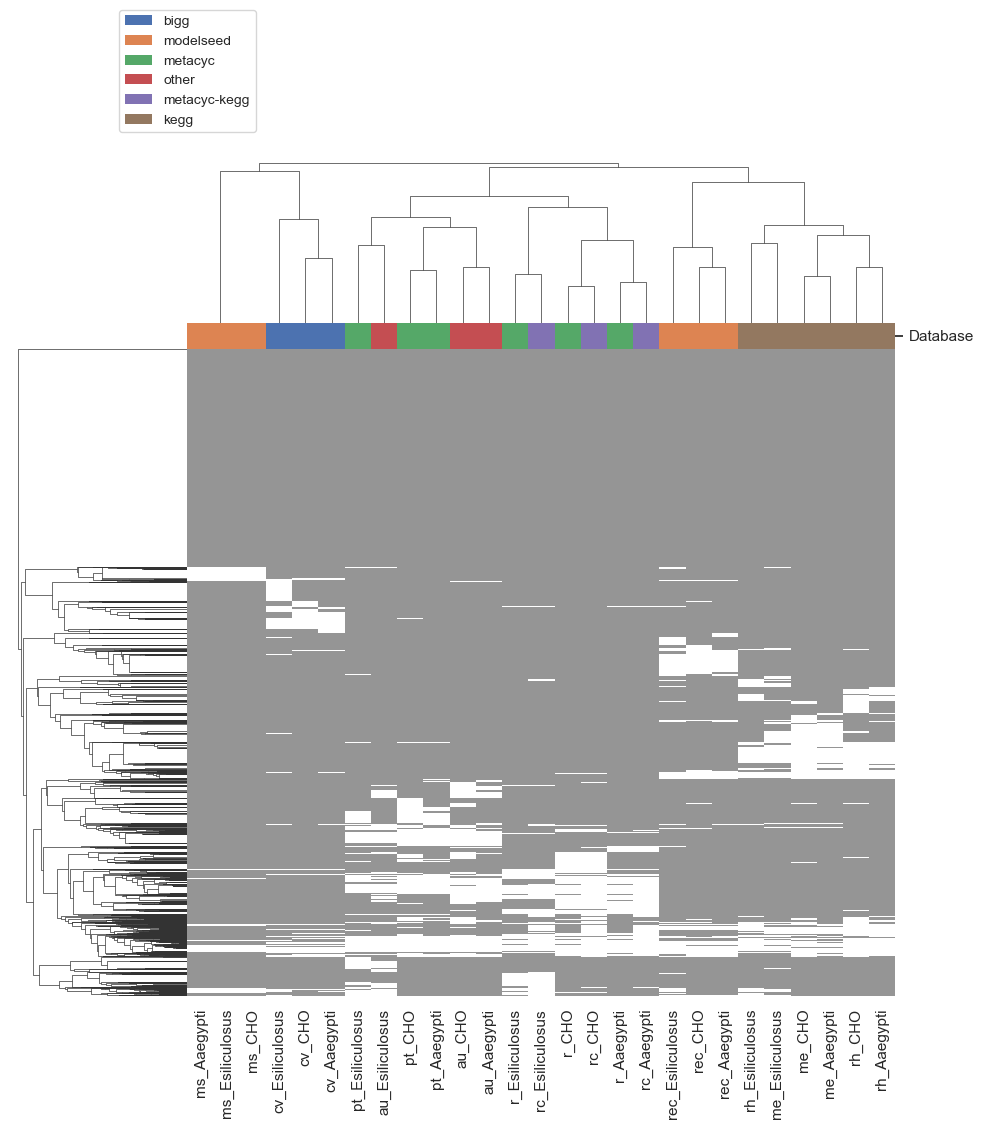

In [14]:
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("white")

cmap = sns.color_palette("Greys", 1)
df = df_rxns
mask = df>0
clustergrid = sns.clustermap(df,method='average', cmap=cmap, center=0, mask = mask, metric='jaccard', yticklabels=False, xticklabels=True, col_colors=col_colors)
# add legends
for label in dbs_plot.unique():
    clustergrid.ax_col_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0);
l1 = clustergrid.ax_col_dendrogram.legend(loc="center", ncol=1, bbox_to_anchor=(0, 1.5), fontsize=10)#, bbox_transform=gcf().transFigure)
clustergrid.cax.set_visible(False) #no colorbar
#clustergrid.savefig('dend_rxns.png', dpi=300)

## Dendogram metabolite mapping
Code for performing metabolite mapping is provided below. Since it depends on data from Metacyc, a file with already performed mappings is provided as supplementary material in this manuscript

In [114]:
dbs_df = pd.DataFrame.from_dict(dbs_plot, orient="index", columns=["Database"])
rxn_names = dbs_df.index
dbs_plot = dbs_df.pop("Database")
lut = dict(zip(dbs_plot.unique(), sns.color_palette("colorblind", len(dbs_plot.unique()))))#it was pastel
col_colors = dbs_plot.map(lut)
col_colors=col_colors.to_frame()
col_colors.index = model_names
col_colors.columns = ['Database']

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


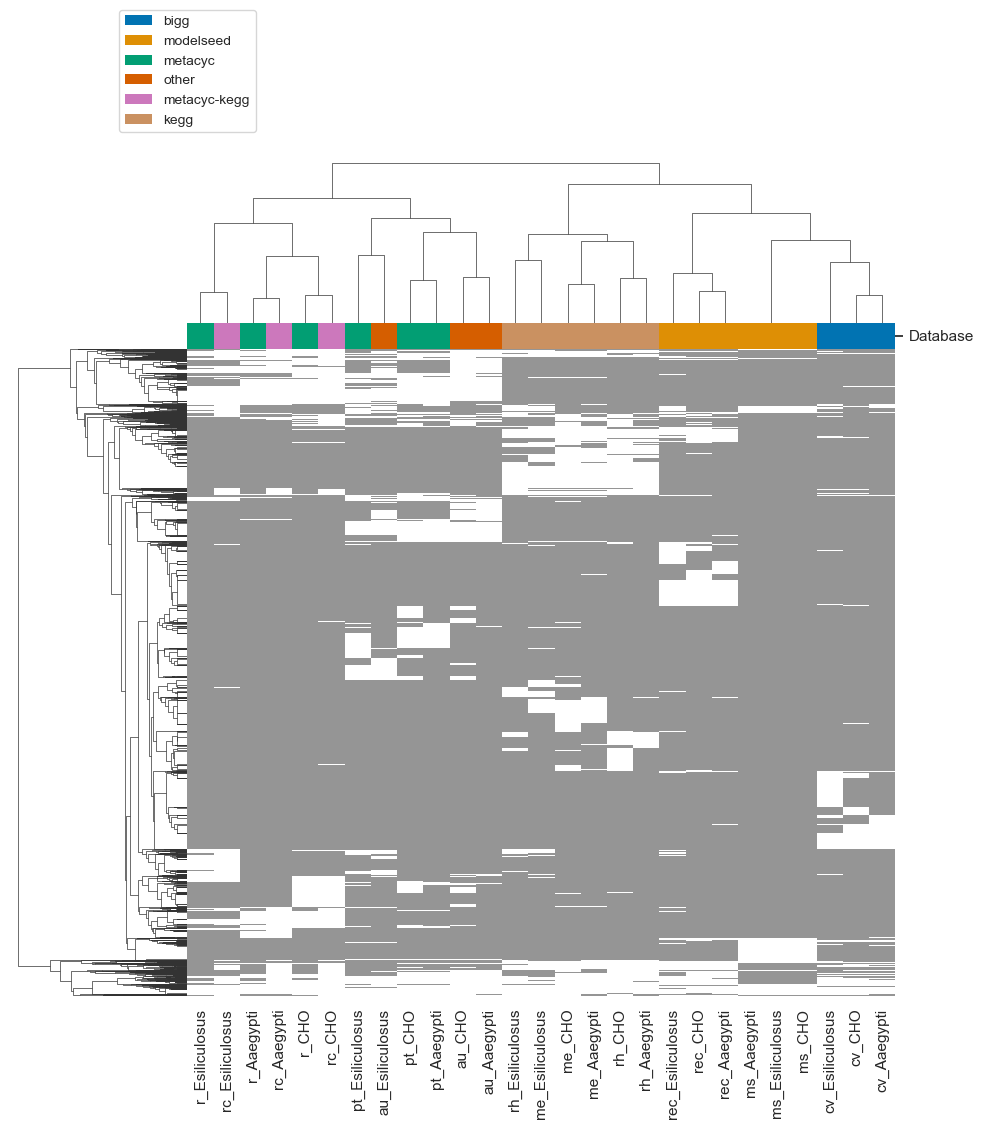

In [47]:
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("white")

cmap = sns.color_palette("Greys", 1)
df = df_rxns
mask = df>0
clustergrid = sns.clustermap(df,method='average', cmap=cmap, center=0, mask = mask, metric='jaccard', yticklabels=False, xticklabels=True, col_colors=col_colors)

# add legends
for label in dbs_plot.unique():
    clustergrid.ax_col_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0);
l1 = clustergrid.ax_col_dendrogram.legend(loc="center", ncol=1, bbox_to_anchor=(0, 1.5), fontsize=10)#, bbox_transform=gcf().transFigure)
clustergrid.cax.set_visible(False) #no colorbar
clustergrid.savefig('dend_rxns_MNX.png', dpi=300) 

## Compartment analysis plot

Load xlsx with Mika's data from compartments (compartment_analysis.csv)

In [84]:
file_path = 'compartment_analysis.csv'
comp_df = pd.read_csv(file_path, sep=';')

In [86]:
comp_df.index = comp_df['model']

In [91]:
comp_df = comp_df[comp_df['Organism']!= 'M_pyrifera']
comp_df = comp_df[comp_df['Organism']!= 'S_japonica']

<Axes: xlabel='model'>

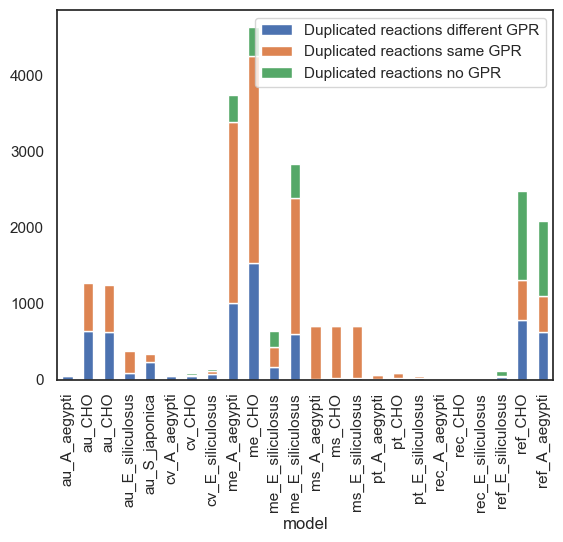

In [92]:
comp_df.plot.bar(stacked=True)


In [93]:
comp_df

,'Tool/File',model,Tool,Organism,Duplicated reactions different GPR,Duplicated reactions same GPR,Duplicated reactions no GPR
model,,,,,,,
au_A_aegypti,'Aureme\Aedes_Aureme.sbml',au_A_aegypti,AuReMe,A_aegypti,46,14,0
au_CHO,'Aureme\CHO_Aureme.sbml',au_CHO,AuReMe,CHO,637,637,0
au_CHO,'Aureme\CHO_Recon.sbml',au_CHO,AuReMe,CHO,631,611,0
au_E_siliculosus,'Aureme\Ectocarpus_Aureme.sbml',au_E_siliculosus,AuReMe,E_siliculosus,87,289,0
au_S_japonica,'Aureme\Ecto_Saccharina_Aureme.sbml',au_S_japonica,AuReMe,E_siliculosus,229,107,0
cv_A_aegypti,'CarveMe\A_aegypti.xml',cv_A_aegypti,carveMe,A_aegypti,41,12,14
cv_CHO,'CarveMe\CHO.xml',cv_CHO,carveMe,CHO,43,20,29
cv_E_siliculosus,'CarveMe\E_siliculosus.xml',cv_E_siliculosus,carveMe,E_siliculosus,78,37,26
me_A_aegypti,'Merlin\Aedes_merlin_support.xml',me_A_aegypti,Merlin,A_aegypti,1010,2374,358


In [96]:
#cv, pt, rec and ref / delete aureme, merlin, modelseed

plot_df = comp_df[comp_df['Tool']!= 'AuReMe']
plot_df = plot_df[plot_df['Tool']!= 'Merlin']
plot_df = plot_df[plot_df['Tool']!= 'Modelseed']
plot_df = plot_df[plot_df['model']!= 'ref_CHO']
plot_df = plot_df[plot_df['model']!= 'ref_A_aegypti']

<Axes: xlabel='model'>

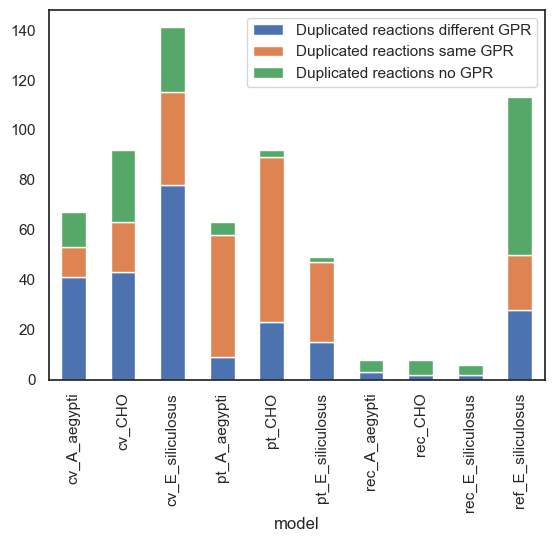

In [97]:
plot_df.plot.bar(stacked=True)

## S2: reactions with associated genes in generated models using modelseed

In [27]:
ms_sub = pd.read_csv('./DB/ModelSEED_Subsystems.tsv', sep='\t')

In [36]:
ms_sub

,Class,Sub-class,Name,Role,Reaction
0,-,-,CBSS-155864.1.peg.3753,Glutamate synthase [NADPH] small chain (EC 1.4...,rxn00085
1,-,-,COG0523,Carbonic anhydrase (EC 4.2.1.1),rxn00102
2,-,-,COG0523,Dihydroorotase (EC 3.5.2.3),rxn01465
3,-,-,COG0523,GTP cyclohydrolase I (EC 3.5.4.16) type 1,rxn00299
4,-,-,COG0523,GTP cyclohydrolase I (EC 3.5.4.16) type 1,rxn00302
...,...,...,...,...,...
9815,Virulence,Resistance to antibiotics and toxic compounds,Resistance_to_fluoroquinolones,DNA gyrase subunit B (EC 5.99.1.3),rxn13783
9816,Virulence,Resistance to antibiotics and toxic compounds,Resistance_to_fluoroquinolones,Topoisomerase IV subunit A (EC 5.99.1.-),rxn13783
9817,Virulence,Resistance to antibiotics and toxic compounds,Resistance_to_fluoroquinolones,Topoisomerase IV subunit B (EC 5.99.1.-),rxn13783
9818,Virulence,"Type III, Type IV, Type VI, ESAT secretion sys...",Type_IV_pilus,3-dehydroquinate synthase (EC 4.2.3.4),rxn02212


In [77]:
path = './to_plot/modelseed/'

orgs = ['A_aegypti', 'CHO', 'E_siliculosus']
#orgs = ['E_siliculosus']
ms_org_dict = dict()
for org in orgs:
    print(org)
    model = cobra.io.read_sbml_model(path+org+'.xml')
    gene_rxns = []
    for r in model.reactions:
        gpr = r.gpr._genes
        if not ((len(gpr)==1 and 'Unknown' in gpr) or len(gpr)==0):
            #print(len(r.genes))
            r_id = r.id.split('_',1)
            gene_rxns.append(r_id[0])

    sub_list = []
    for r in gene_rxns:
        sdf = ms_sub[ms_sub['Reaction']==r]
        sub_df = ms_sub[ms_sub['Reaction']==r]['Class']
        if not sub_df.empty:
            sub = sub_df.tolist()[0]
            print(sub)
            if (sub=='Experimental Subsystems' or sub=='Clustering-based subsystems') and len(sub_df.tolist())>1:
                sub = sub_df.tolist()[1]
                sub_list.append(sub)
            else:
                sub_list.append(sub)
        else:
            
            print(sdf)
            print(r)
            sub_list.append('-')
    
    dict_sub = {i:sub_list.count(i) for i in sub_list}
    ms_org_dict[org] = dict_sub

A_aegypti
CHO
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Carbohydrates
Carbohydrates
Amino Acids and Derivatives
Amino Acids and Derivatives
Clustering-based subsystems
Clustering-based subsystems
Empty DataFrame
Columns: [Class, Sub-class, Name, Role, Reaction]
Index: []
rxn00078
Empty DataFrame
Columns: [Class, Sub-class, Name, Role, Reaction]
Index: []
rxn00078
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Amino Acids and Derivatives
Empty DataFrame
Columns: [Class, Sub-class, Name, Role, Reaction]
Index: []
rxn00116
Empty DataFrame
Columns: [Class, Sub-class, Name, Role, Reaction]
Index: []
rxn00116
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Clustering-based subsystems
Empty DataFrame
Columns: [Class, Sub-class

Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Carbohydrates
Carbohydrates
Amino Acids and Derivatives
Amino Acids and Derivatives
Cofactors, Vitamins, Prosthetic Groups, Pigments
Empty DataFrame
Columns: [Class, Sub-class, Name, Role, Reaction]
Index: []
rxn00069
Empty DataFrame
Columns: [Class, Sub-class, Name, Role, Reaction]
Index: []
rxn00078
Empty DataFrame
Columns: [Class, Sub-class, Name, Role, Reaction]
Index: []
rxn00078
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Amino Acids and Derivatives
-
-
Cofactors, Vitamins, Prosthetic Groups, Pigments
Empty DataFrame
Columns: [Class, Sub-class, Name, Role, Reaction]
Index: []
rxn00116
Empty DataFrame
Columns: [Class, Sub-class, Name, Role, Reaction]
Index: []
rxn00116
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
E

In [79]:
pd.DataFrame.from_dict(ms_org_dict).fillna(0).to_csv('S2.csv', sep=';')

In [31]:
sub_list = []
for r in gene_rxns:
    sub_df = ms_sub[ms_sub['Reaction']==r]['Class']
    if not sub_df.empty:
        sub = sub_df.tolist()[0]
        print(sub)
        if (sub=='Experimental Subsystems' or sub=='Clustering-based subsystems') and len(sub_df.tolist())>1:
            sub = sub_df.tolist()[1]
            sub_list.append(sub)
        else:
            sub_list.append(sub)
    else:
        sub_list.append('-')

dict_sub = {i:sub_list.count(i) for i in sub_list}
        

Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Carbohydrates
Carbohydrates
Amino Acids and Derivatives
Amino Acids and Derivatives
Carbohydrates
Carbohydrates
Cofactors, Vitamins, Prosthetic Groups, Pigments
Clustering-based subsystems
Clustering-based subsystems
Cofactors, Vitamins, Prosthetic Groups, Pigments
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Clustering-based subsystems
Clustering-based subsystems
Amino Acids and Derivatives
-
-
Cofactors, Vitamins, Prosthetic Groups, Pigments
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Experimental Subsystems
Clustering-based subsystems
Clustering-based subsystems
Clustering-based subsystems
Cofactors, Vitamins, Prosthetic Groups, Pigments
Cofactors, Vitamins, Prosthetic Groups, Pigments
Amino A

In [32]:
sub_df = ms_sub[ms_sub['Reaction']=='rxn00006']['Class'].tolist()[0]

In [33]:
dict_sub

{'Phosphorus Metabolism': 5,
 'Carbohydrates': 97,
 'Amino Acids and Derivatives': 134,
 'Cofactors, Vitamins, Prosthetic Groups, Pigments': 74,
 '-': 636,
 'Stress Response': 3,
 'Nucleosides and Nucleotides': 61,
 'Clustering-based subsystems': 16,
 'Experimental Subsystems': 25,
 'Cell Division and Cell Cycle': 1,
 'Fatty Acids, Lipids, and Isoprenoids': 16,
 'Cell Wall and Capsule': 15,
 'Membrane Transport': 1}

## S3 Template influence in AuReMe models


In [10]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted
import pandas as pd

# Crear DataFrame con la información de los gráficos
data = {
    'Nombre archivo': ['Aedes_genes.pdf', 'Aedes_genome.pdf', 'Aedes_metabolites.pdf', 
                       'Ectocarpus_genes.pdf', 'Ectocarpus_genome.pdf', 'Ectocarpus_metabolites.pdf', 
                       'Cricetulus_genes.pdf', 'Cricetulus_genome.pdf', 'Cricetulus_metabolites.pdf'],
    'A': [1124, 0, 74, 46, 0, 515, 95, 15, 15],
    'B': [163, 0, 1173, 1671, 0, 1265, 66, 11, 12],
    'A∩B': [651, 0, 118, 90, 0, 187, 1651, 297, 1677],
    'C': [0, 21249, 117, 0, 11741, 128, 0, 19399, 143],
    'A∩C': [0, 436, 15, 0, 46, 0, 0, 18, 0],
    'B∩C': [0, 59, 0, 0, 1671, 14, 0, 9, 0],
    'A∩B∩C': [6454, 6574, 2055, 2721, 2811, 2322, 4503, 4812, 2520],
    'Titulo A': ['A_aegypti_Dme', 'A_aegypti_Dme', 'A_aegypti_Dme', 'E_siliculosus_Cre', 'E_siliculosus_Cre', 'E_siliculosus_Cre', 
                 'C_griseus_Mmu', 'C_griseus_Mmu', 'C_griseus_Mmu'],
    'Titulo B': ['A_aegypti_Hsa', 'A_aegypti_Hsa', 'A_aegypti_Hsa', 'E_siliculosus_Sjap', 'E_siliculosus_Sjap', 'E_siliculosus_Sjap', 
                 'C_griseus_Hsa', 'C_griseus_Hsa', 'C_griseus_Hsa'],
    'Titulo C': ['A_aegypti', 'ge_A_aegypti', 'A_aegypti', 'E_siliculosus', 'ge_E_siliculosus', 'E_siliculosus', 
                 'C_griseus', 'ge_C_griseus', 'C_griseus']
}

df = pd.DataFrame(data)

# Iterar sobre cada fila del DataFrame para generar los gráficos
for index, row in df.iterrows():
    subset_sizes = (row['A'], row['B'], row['A∩B'], row['C'], row['A∩C'], row['B∩C'], row['A∩B∩C'])
    
    # Crear el diagrama de Venn no ponderado (círculos simétricos)
    venn_diagram = venn3_unweighted(subsets=subset_sizes, set_labels=(row['Titulo A'], row['Titulo B'], row['Titulo C']))

    # Configurar la fuente a Arial
    for text in venn_diagram.set_labels:
        text.set_fontsize(16)
        text.set_fontfamily('Arial')

    for text in venn_diagram.subset_labels:
        if text:  # Puede haber etiquetas de subconjuntos que sean None
            text.set_fontsize(14)
            text.set_fontfamily('Arial')
    # Exportar el diagrama como archivo PDF
    plt.savefig(row['Nombre archivo'], format='pdf', bbox_inches='tight')
    plt.close()  # Cerrar la figura para evitar que se sobrepongan en el siguiente gráfico


## Venn diagram type comparison

In [2]:
import logging

logging.getLogger("cobra").setLevel(logging.ERROR)


In [15]:
methods_to_plot = ['carveMe', 'merlin', 'modelseed', 'raven_homo',
       'reconstructor', 'raven', 'AuReMe', 'raven_comb', 'pathway_tools']#, 'reference']

mega_dict = dict()    
for method in methods_to_plot:
    if len(methods_to_plot) == 0:
            methods_to_plot = os.listdir('./to_plot/')
    if not method.startswith('.'):  
        if method in methods_to_plot:
            method_dict = dict()
            print(method)
            for org in os.listdir('./to_plot/'+method):
                if not org.startswith('.') and ( org.endswith('.xml') or org.endswith('.sbml')):
                    org_dict = dict()
                    print(org)
                    d = cobra.io.read_sbml_model('./to_plot/'+method+'/'+org)
                    org_dict = dict()
                    org_dict['metabolites'] = [m.id for m in d.metabolites]
                    org_dict['reactions'] = [r.id for r in d.reactions]
                    org_dict['genes'] = [g.id for g in d.genes]
                    #print(org_dict)
                    org = org.replace('.xml','')
                    org = org.replace('.sbml','')
                    
                    method_dict[org] = org_dict

            mega_dict[method] = method_dict

carveMe
E_siliculosus.xml
CHO.xml
A_aegypti.xml
M_pyrifera.xml
merlin
E_siliculosus.xml
CHO.xml
A_aegypti.xml
M_pyrifera.xml
modelseed
E_siliculosus.xml
CHO.xml
A_aegypti.xml
M_pyrifera.xml


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/core/gene.py:373: SyntaxWarning: Malformed gene_reaction_rule '__cobra_escape__9647706__COBRA_DOT__fgenesh2_kg__COBRA_DOT__23₂TRINITY_DN26574_c2_g1_i3'
  warn(
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/core/gene.py:373: SyntaxWarning: Malformed gene_reaction_rule '(__cobra_escape__9825993__COBRA_DOT__estExt_fgenesh2_pg__COBRA_DOT__C_340070 or __cobra_escape__9511768__COBRA_DOT__fgenesh2_kg__COBRA_DOT__10㋺TRINITY_DN40656_c0_g2_i4)'
  warn(
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/core/gene.py:373: SyntaxWarning: Malformed gene_reaction_rule '(__cobra_escape__9411666__COBRA_DOT__fgenesh2_kg__COBRA_DOT__4༗TRINITY_DN38246_c0_g1_i4 or __cobra_escape__1230796__COBRA_DOT__estExt_Genewise1Plus__COBRA_DOT__C_27_t10017 or __cobra_escape__8862649__COBRA_DOT__g15477__COBRA_DOT__t1)'
  warn(
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/

raven_homo
E_siliculosus.xml


No objective coefficients in model. Unclear what should be optimized


CHO.xml


No objective coefficients in model. Unclear what should be optimized


A_aegypti.xml


No objective coefficients in model. Unclear what should be optimized


M_pyrifera.xml


No objective coefficients in model. Unclear what should be optimized


reconstructor
CHO.sbml
A_aegypti.sbml
E_siliculosus.sbml
M_pyrifera.sbml
raven
E_siliculosus.xml


No objective coefficients in model. Unclear what should be optimized


CHO.xml


No objective coefficients in model. Unclear what should be optimized


A_aegypti.xml


No objective coefficients in model. Unclear what should be optimized


M_pyrifera.xml


No objective coefficients in model. Unclear what should be optimized


AuReMe
E_siliculosus.xml


No objective coefficients in model. Unclear what should be optimized


CHO.xml


No objective coefficients in model. Unclear what should be optimized


A_aegypti.xml


No objective coefficients in model. Unclear what should be optimized


M_pyrifera.xml


No objective coefficients in model. Unclear what should be optimized


raven_comb
E_siliculosus.xml


No objective coefficients in model. Unclear what should be optimized


CHO.xml
A_aegypti.xml
M_pyrifera.xml


No objective coefficients in model. Unclear what should be optimized


pathway_tools
E_siliculosus.xml


No objective coefficients in model. Unclear what should be optimized


CHO.xml


No objective coefficients in model. Unclear what should be optimized


A_aegypti.xml


No objective coefficients in model. Unclear what should be optimized


M_pyrifera.xml


No objective coefficients in model. Unclear what should be optimized


In [16]:
for k in mega_dict.keys():
    print(k)
    print(len(mega_dict[k]))

carveMe
4
merlin
4
modelseed
4
raven_homo
4
reconstructor
4
raven
4
AuReMe
4
raven_comb
4
pathway_tools
4


In [17]:
mega_dict['carveMe']

{'E_siliculosus': {'metabolites': ['10fthf_c',
   '12dgr140_c',
   '12dgr140_p',
   '12dgr160_c',
   '12dgr160_p',
   '12dgr161_c',
   '12dgr180_c',
   '12dgr180_p',
   '12dgr181_c',
   '12dgr181_p',
   '12ppd__R_c',
   '12ppd__S_c',
   '13dpg_c',
   '15dap_c',
   '1btol_c',
   '1ddecg3p_c',
   '1hdec9eg3p_c',
   '1p3h5c_c',
   '1pyr5c_c',
   '1tdec7eg3p_c',
   '23dhdp_c',
   '23dhmb_c',
   '23dhmp_c',
   '25aics_c',
   '25dhpp_c',
   '25dkglcn_c',
   '25dkglcn_e',
   '25dkglcn_p',
   '25drapp_c',
   '26dap_LL_c',
   '26dap__M_c',
   '26dap__M_e',
   '26dap__M_p',
   '2agpe120_c',
   '2agpe120_p',
   '2agpe141_c',
   '2agpe141_p',
   '2agpe161_c',
   '2agpe161_p',
   '2agpg120_c',
   '2agpg120_p',
   '2agpg140_c',
   '2agpg140_p',
   '2agpg141_c',
   '2agpg141_p',
   '2agpg160_c',
   '2agpg160_p',
   '2agpg161_c',
   '2agpg161_p',
   '2agpg180_c',
   '2agpg180_p',
   '2agpg181_c',
   '2agpg181_p',
   '2ahbut_c',
   '2ahhmd_c',
   '2ahhmp_c',
   '2amsa_c',
   '2aobut_c',
   '2cpr5p_c',


In [18]:
def get_plot_dict(mega_dict, org, what):
    #mega_dict with all the data
    #org organism to plot
    #what: what is going to be ploted (metabolites, genes, reactions)
    plot_dict = dict()
    for k in mega_dict.keys():
        print(k)
        print(org)
        print(what)

        plot_dict[k] = mega_dict[k][org][what]
    
    return(plot_dict)

In [30]:
plot_dict = get_plot_dict(mega_dict, 'A_aegypti', 'genes') #TO DO: add "curated model" to list

carveMe
A_aegypti
genes
merlin
A_aegypti
genes
modelseed
A_aegypti
genes
raven_homo
A_aegypti
genes
reconstructor
A_aegypti
genes
raven
A_aegypti
genes
AuReMe
A_aegypti
genes
raven_comb
A_aegypti
genes
pathway_tools
A_aegypti
genes


In [31]:
plot_dict['carveMe']

['XP_001649088_2',
 'XP_021696045_1',
 'XP_001662725_1',
 'XP_001655922_3',
 'XP_001660495_2',
 'XP_021699427_1',
 'XP_021712728_1',
 'XP_021703416_1',
 'XP_021703414_1',
 'XP_001652320_1',
 'XP_001652321_1',
 'XP_021705428_1',
 'XP_021696903_1',
 'XP_021707535_1',
 'XP_021696900_1',
 'spontaneous',
 'XP_021698259_1',
 'XP_021698257_1',
 'XP_021698264_1',
 'XP_021698263_1',
 'XP_021698260_1',
 'XP_001655519_1',
 'XP_001651965_2',
 'XP_001661733_1',
 'XP_001653814_1',
 'XP_021701091_1',
 'XP_001659894_2',
 'XP_001655181_1',
 'XP_001659032_1',
 'XP_001663037_1',
 'XP_001647648_2',
 'XP_001647999_2',
 'XP_021712595_1',
 'XP_001658626_2',
 'XP_021706230_1',
 'XP_021698494_1',
 'XP_001661093_2',
 'XP_011493633_2',
 'XP_021698248_1',
 'XP_001663301_2',
 'XP_021696170_1',
 'XP_001659011_2',
 'XP_001659406_1',
 'XP_021705139_1',
 'XP_021694152_1',
 'XP_021698106_1',
 'XP_001656636_2',
 'XP_001653725_2',
 'XP_021698105_1',
 'XP_001657342_1',
 'XP_021702935_1',
 'XP_021709368_1',
 'XP_001662844_

In [32]:
plot_dict

#in this particular case carveMe has genes plotted without points

for k in plot_dict.keys():
    plot_dict[k] = [g.replace('GENE_','') for g in plot_dict[k]]
    plot_dict[k] = [g.replace('jgi_Macpyr2_','') for g in plot_dict[k]]
    if "." in plot_dict[k][0]:
        plot_dict[k] = [g.split('.')[0] for g in plot_dict[k]]
    elif "_" in plot_dict[k][0]:
        plot_dict[k] = [g.split('_')[0] for g in plot_dict[k]]
    
    plot_dict[k] = list(set(plot_dict[k]))
    #if k != 'reconstructor':
    #    plot_dict[k] = [g[:-2] for g in plot_dict[k]]
    #remove 'GENE_'    
    

In [33]:
import upsetplot
from upsetplot import from_contents

In [34]:
#RA_genes, CM_genes, PT_genes
genes = from_contents(plot_dict)


In [35]:
genes

id
carveMe merlin modelseed raven_homo reconstructor raven AuReMe raven_comb pathway_tools              
True    True   False     False      False         False False  False      False                    XP
        False  False     False      False         False False  False      False           spontaneous
False   True   False     False      False         False False  False      False                    YP
        False  True      False      False         False False  False      False               Unknown
               False     True       False         False False  True       True           XP_021693396
...                                                                                               ...
                         False      False         False False  False      True           XP_021698945
                                                                          True           XP_021693466
                                                                          True           XP_021709973
                                                                          True           XP_021706186
                                                                          True           XP_021703379

[7909 rows x 1 columns]

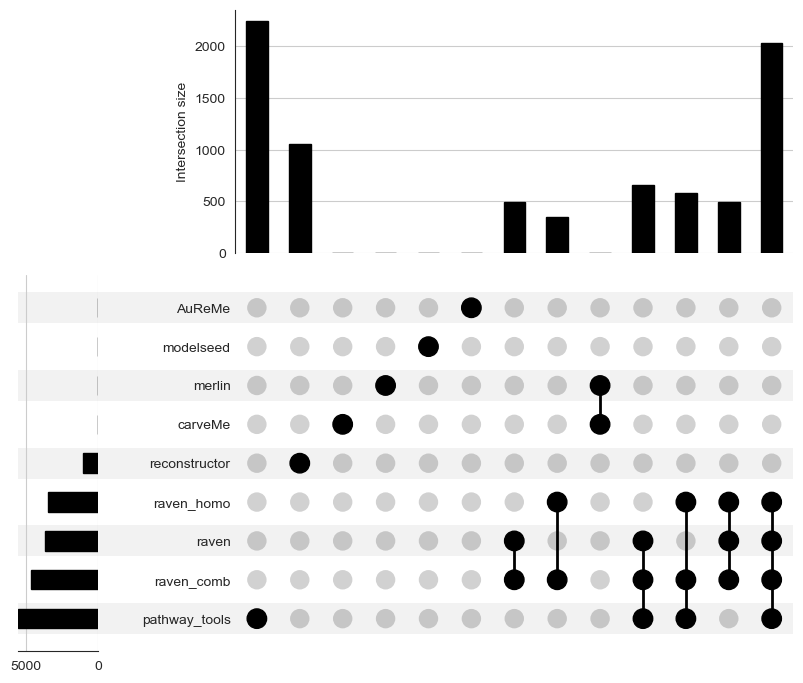

In [36]:
from upsetplot import UpSet

ax_dict = UpSet(genes, subset_size='count', element_size=40).plot()

# Complete matrix reaction mapping

In [21]:
#new rxn map
prefix = 'presence_matrix_rxn_mix_strategy_'
folder = './reaction_map/'
dict_rxn_df = dict()
for file in os.listdir(folder):
    if file.endswith('.csv'): #possible issues with .ds_store
        df_dict = pd.read_csv(folder+file, index_col=0).to_dict() #gets a dict with worksheet names as keys
        org_id = file.replace('.csv','')
        org_id = org_id.replace(prefix,'')
        for k in df_dict.keys():
            dict_rxn_df[k+'_'+org_id] = df_dict[k]

In [22]:
df_rxns = pd.DataFrame.from_dict(dict_rxn_df).fillna(0)

In [23]:
df_rxns

,carveme_CHO,seed_CHO,pathway tools_CHO,aureme_CHO,raven_CHO,raven comb_CHO,raven homo_CHO,merlin_CHO,reconstructor_CHO,aureme2_CHO,...,pathway tools_A_aegypti,aureme_A_aegypti,raven_A_aegypti,raven comb_A_aegypti,raven homo_A_aegypti,merlin_A_aegypti,reconstructor_A_aegypti,aureme2_A_aegypti,aureme3_A_aegypti,aureme4_A_aegypti
MNXR02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
MNXR100024,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
MNXR100060,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
MNXR100074,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
MNXR100098,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m12_HMR_9590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
m12_HMR_9610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
m12_HMR_9611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
m12_HMR_9620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
#Load metacyc file and make dict
file_id = 'reac_xref.tsv'
metacyc_rxn_dict = dict()
##source	ID	description (file structure when it does not start with an #)
f = open(file_id, "r")
for line in f:
    if not line.startswith('#'):
        source, id, description = line.split('\t')
        #print(source) #clean source
        if ':' in source:
            rxn = source.split(':')[1]
            if rxn.startswith('R_'):
                rxn = rxn.split('R_')[1]                      
        else:
            rxn = source
        metacyc_rxn_dict[rxn] = id
            
        #metacyc_rxn_dict[
#print(f.read())

In [ ]:
#flag = ['EX_', 'sink'] 
NF_list = list()
change_id_dict = dict()
for k in dict_rxn_df.keys():
    this_model = dict_rxn_df[k]
    for key in this_model.keys():
        if not key.startswith('MNX'):
            rxn = key
            if key.startswith('m'): #regular expression?
                rxn = key.split('_',1)[1]
            if rxn.startswith('R_'):
                rxn = key.split('R_',1)[1]
            #print(rxn)
            if rxn in metacyc_rxn_dict.keys():
                meta_id =  metacyc_rxn_dict[rxn]
            elif '/' in rxn:
                #from pathway tools
                #print(rxn)
                if rxn.startswith('TRANS-RXN'):
                    #print(rxn)
                    rxn = 'TRANS-RXN-'+rxn.split('-',3)[2]
                    #print(rxn)
                elif rxn.startswith('RXN-'):
                    rxn = 'RXN-'+rxn.split('-',2)[1]
                elif rxn.startswith('RXN0-'):
                    rxn = 'RXN0-'+rxn.split('-',2)[1]
                elif rxn.startswith('RXN'):
                    rxn = 'RXN'+rxn.split('-',2)[1]
                else:
                    rxn = rxn.split('-RXN',1)[0]+'-RXN' #case ends with RXN there is also a case when it starts with RXN as well
                
                
                if rxn.startswith('-'):
                    rxn = rxn[1:]
                if rxn.startswith('_'):
                    rxn = rxn[1:]
                if rxn in metacyc_rxn_dict.keys():
                    #print('found!')
                    meta_id =  metacyc_rxn_dict[rxn]
                    #drop old entry
                    change_id_dict[key] = meta_id
                    
                    #del this_model[key] -> can't change dict on iteration
                    #this_model[key] = 0 #delete rows with all zeros afterwards
                else:
                    #print(key)
                    #print('NF')
                    NF_list.append(rxn)
                    #print(rxn)
            else:
                #endswith __cytop (merlin type )
                print(key)
                print(rxn)
                NF_list.append(rxn)
                
                
            

In [32]:
NF_list

['sink_lipopb_c',
 'EX_gly_leu_e',
 'Growth',
 'EX_cpd00001_e0',
 'EX_cpd00007_e0',
 'EX_cpd00009_e0',
 'EX_cpd00011_e0',
 'EX_cpd00013_e0',
 'EX_cpd00048_e0',
 'EX_cpd00067_e0',
 'EX_cpd00073_e0',
 'EX_cpd00075_e0',
 'EX_cpd00076_e0',
 'EX_cpd00099_e0',
 'EX_cpd00204_e0',
 'EX_cpd00205_e0',
 'EX_cpd00209_e0',
 'EX_cpd02701_c0',
 'EX_cpd02701_m0',
 'EX_cpd11416_c0',
 'EX_cpd11632_e0',
 'bio1',
 'bio2',
 'RXN-12440',
 'RXN-22452',
 'RXN-22452',
 'RXN-22452',
 'RXN-22497',
 'RXN-22500',
 'RXN-22515',
 'RXN-22603',
 'RXN-22604',
 'RXN-22605',
 'RXN-22606',
 'RXN-22613',
 'RXN-22618',
 'RXN-22624',
 'RXN-22643',
 'RXN-22697',
 'RXN-22698',
 'RXN-22700',
 'RXN-22715',
 'RXN-22741',
 'RXN-22774',
 'RXN-22775',
 'RXN-22776',
 'RXN-22777',
 'RXN-22778',
 'RXN-22790',
 'RXN-22817',
 'RXN-22817',
 'RXN-22817',
 'RXN-22909',
 'RXN-22910',
 'RXN-22911',
 'RXN-22914',
 'RXN-22915',
 'RXN-22953',
 'RXN-22955',
 'RXN-22966',
 'RXN-22967',
 'RXN-22994',
 'RXN-23003',
 'RXN-23004',
 'RXN-23005',
 'RXN-

In [26]:
change_id_dict

{'m3_ACYLCARNITINE-HYDROLASE-RXN-CPD-19742/WATER//CARNITINE/STEARIC_ACID/PROTON.47.': 'MNXR115668',
 'm3_ACYLCARNITINE-HYDROLASE-RXN-CPD-24165/WATER//CARNITINE/ARACHIDONIC_ACID/PROTON.51.': 'MNXR115668',
 'm3_ACYLCOADEHYDROG-RXN-CPD-196/ETF-Oxidized/PROTON//CPD-23631/ETF-Reduced.51.': 'MNXR115669',
 'm3_ACYLCOADEHYDROG-RXN-HEXANOYL-COA/ETF-Oxidized/PROTON//POLYMER-INST-TRANS-D2-ENOYL-COA-C2-H4/ETF-Reduced.84.': 'MNXR115669',
 'm3_ACYLCOADEHYDROG-RXN-LAUROYLCOA-CPD/ETF-Oxidized/PROTON//POLYMER-INST-TRANS-D2-ENOYL-COA-C8-H16/ETF-Reduced.87.': 'MNXR115669',
 'm3_ACYLCOADEHYDROG-RXN-POLYMER-INST-Saturated-Fatty-Acyl-CoA-C16-H32/ETF-Oxidized/PROTON//POLYMER-INST-TRANS-D2-ENOYL-COA-C16-H32/ETF-Reduced.119.': 'MNXR115669',
 'm3_ACYLCOADEHYDROG-RXN-TETRADECANOYL-COA/ETF-Oxidized/PROTON//POLYMER-INST-TRANS-D2-ENOYL-COA-C10-H20/ETF-Reduced.91.': 'MNXR115669',
 'm3_ACYLCOASYN-RXN-ARACHIDIC_ACID/CO-A/ATP//POLYMER-INST-Saturated-Fatty-Acyl-CoA-C16-H32/PPI/AMP.79.': 'MNXR115670',
 'm3_ACYLCOASYN-RXN

In [27]:
NF_list

['sink_lipopb_c',
 'EX_gly_leu_e',
 'Growth',
 'EX_cpd00001_e0',
 'EX_cpd00007_e0',
 'EX_cpd00009_e0',
 'EX_cpd00011_e0',
 'EX_cpd00013_e0',
 'EX_cpd00048_e0',
 'EX_cpd00067_e0',
 'EX_cpd00073_e0',
 'EX_cpd00075_e0',
 'EX_cpd00076_e0',
 'EX_cpd00099_e0',
 'EX_cpd00204_e0',
 'EX_cpd00205_e0',
 'EX_cpd00209_e0',
 'EX_cpd02701_c0',
 'EX_cpd02701_m0',
 'EX_cpd11416_c0',
 'EX_cpd11632_e0',
 'bio1',
 'bio2',
 'RXN-12440',
 'RXN-22452',
 'RXN-22452',
 'RXN-22452',
 'RXN-22497',
 'RXN-22500',
 'RXN-22515',
 'RXN-22603',
 'RXN-22604',
 'RXN-22605',
 'RXN-22606',
 'RXN-22613',
 'RXN-22618',
 'RXN-22624',
 'RXN-22643',
 'RXN-22697',
 'RXN-22698',
 'RXN-22700',
 'RXN-22715',
 'RXN-22741',
 'RXN-22774',
 'RXN-22775',
 'RXN-22776',
 'RXN-22777',
 'RXN-22778',
 'RXN-22790',
 'RXN-22817',
 'RXN-22817',
 'RXN-22817',
 'RXN-22909',
 'RXN-22910',
 'RXN-22911',
 'RXN-22914',
 'RXN-22915',
 'RXN-22953',
 'RXN-22955',
 'RXN-22966',
 'RXN-22967',
 'RXN-22994',
 'RXN-23003',
 'RXN-23004',
 'RXN-23005',
 'RXN-

In [231]:
mod_dict = dict_rxn_df.copy() #modified dict

for model in dict_rxn_df.keys():
    this_model = dict_rxn_df[model]
    for rxn in list(this_model.keys()):
        if rxn in change_id_dict.keys():
            mod_dict[change_id_dict[rxn]] = mod_dict[model][rxn]
            del mod_dict[model][rxn]
            


In [241]:
for r in mod_dict[model].keys():
    if not r.startswith('MNX'):
        print(r)

R_DHR_1
R_DNTAep
R_GALUR_Et
R_H2CO3D2
R_MDNTHAep
R_METSR_R1
R_METSR_R2
R_METSR_S1
R_METSR_S2
R_NH3c
R_NOR_syn_1
R_SALCHS4FEtonex
R_SALCHS4tex
R_SULR_syn
R_sink_hemeO_c
R_sink_mobd_c
R_EX_actn__R_e
R_EX_pnto__R_e
Growth
m2_EX_cpd00001_e0
m2_EX_cpd00007_e0
m2_EX_cpd00009_e0
m2_EX_cpd00011_e0
m2_EX_cpd00013_e0
m2_EX_cpd00048_e0
m2_EX_cpd00067_e0
m2_EX_cpd00073_e0
m2_EX_cpd00075_e0
m2_EX_cpd00076_e0
m2_EX_cpd00099_e0
m2_EX_cpd00204_e0
m2_EX_cpd00205_e0
m2_EX_cpd00209_e0
m2_EX_cpd02701_c0
m2_EX_cpd02701_m0
m2_EX_cpd11416_c0
m2_EX_cpd11632_e0
m2_bio1
m2_bio2
m3_RXN-12440
m3_RXN-18232
m3_RXN-22286
m3_RXN-22315
m3_RXN-22316
m3_RXN-22317
m3_RXN-22318
m3_RXN-22319
m3_RXN-22348
m3_RXN-22349
m3_RXN-22388
m3_RXN-22455
m3_RXN-22497
m3_RXN-22603
m3_RXN-22604
m3_RXN-22606
m3_RXN-22610
m3_RXN-22618
m3_RXN-22643
m3_RXN-22697
m3_RXN-22698
m3_RXN-22700
m3_RXN-22715
m3_RXN-22729
m3_RXN-22758
m3_RXN-22762
m3_RXN-22774
m3_RXN-22775
m3_RXN-22776
m3_RXN-22777
m3_RXN-22778
m3_RXN-22790
m3_RXN-22817
m3_RXN-22817

In [242]:
for r in change_id_dict.keys():
    print(r)

m3_ACYLCARNITINE-HYDROLASE-RXN-CPD-19742/WATER//CARNITINE/STEARIC_ACID/PROTON.47.
m3_ACYLCARNITINE-HYDROLASE-RXN-CPD-24165/WATER//CARNITINE/ARACHIDONIC_ACID/PROTON.51.
m3_ACYLCOADEHYDROG-RXN-CPD-196/ETF-Oxidized/PROTON//CPD-23631/ETF-Reduced.51.
m3_ACYLCOADEHYDROG-RXN-HEXANOYL-COA/ETF-Oxidized/PROTON//POLYMER-INST-TRANS-D2-ENOYL-COA-C2-H4/ETF-Reduced.84.
m3_ACYLCOADEHYDROG-RXN-LAUROYLCOA-CPD/ETF-Oxidized/PROTON//POLYMER-INST-TRANS-D2-ENOYL-COA-C8-H16/ETF-Reduced.87.
m3_ACYLCOADEHYDROG-RXN-POLYMER-INST-Saturated-Fatty-Acyl-CoA-C16-H32/ETF-Oxidized/PROTON//POLYMER-INST-TRANS-D2-ENOYL-COA-C16-H32/ETF-Reduced.119.
m3_ACYLCOADEHYDROG-RXN-TETRADECANOYL-COA/ETF-Oxidized/PROTON//POLYMER-INST-TRANS-D2-ENOYL-COA-C10-H20/ETF-Reduced.91.
m3_ACYLCOASYN-RXN-ARACHIDIC_ACID/CO-A/ATP//POLYMER-INST-Saturated-Fatty-Acyl-CoA-C16-H32/PPI/AMP.79.
m3_ACYLCOASYN-RXN-POLYMER-INST-CPD66-39-C2-H4/CO-A/ATP//HEXANOYL-COA/PPI/AMP.59.
m3_ALANINE--OXO-ACID-AMINOTRANSFERASE-RXN-L-ALPHA-ALANINE/2-KETO-6-AMINO-CAPROATE/

In [235]:
mod_df = pd.DataFrame.from_dict(mod_dict).fillna(0)

In [238]:
for i in mod_df.index:
    if not i.startswith('MNX'):
        print(i)

R_DHR_1
R_H2CO3D2
R_HMR_0260
R_NH3c
R_NOR_syn_1
R_SULR_1
R_sink_lipopb_c
R_EX_12ppd__R_e
R_EX_R_3hcmrs7e_e
R_EX_R_3hdda_e
R_EX_R_3hhxa_e
R_EX_R_3hpt_e
R_EX_gly_leu_e
Growth
m2_EX_cpd00001_e0
m2_EX_cpd00007_e0
m2_EX_cpd00009_e0
m2_EX_cpd00011_e0
m2_EX_cpd00013_e0
m2_EX_cpd00048_e0
m2_EX_cpd00067_e0
m2_EX_cpd00073_e0
m2_EX_cpd00075_e0
m2_EX_cpd00076_e0
m2_EX_cpd00099_e0
m2_EX_cpd00204_e0
m2_EX_cpd00205_e0
m2_EX_cpd00209_e0
m2_EX_cpd02701_c0
m2_EX_cpd02701_m0
m2_EX_cpd11416_c0
m2_EX_cpd11632_e0
m2_bio1
m2_bio2
m3_RXN-12440
m3_RXN-18232
m3_RXN-22286
m3_RXN-22315
m3_RXN-22316
m3_RXN-22317
m3_RXN-22318
m3_RXN-22319
m3_RXN-22348
m3_RXN-22388
m3_RXN-22452
m3_RXN-22452-CPD-24470/WATER//CPD-15972/CPD0-1123.37.
m3_RXN-22452-CPD-24470/WATER//CPD-15972/CPD0-2701.37.
m3_RXN-22497
m3_RXN-22500
m3_RXN-22515
m3_RXN-22603
m3_RXN-22604
m3_RXN-22605
m3_RXN-22606
m3_RXN-22613
m3_RXN-22618
m3_RXN-22624
m3_RXN-22643
m3_RXN-22697
m3_RXN-22698
m3_RXN-22700
m3_RXN-22715
m3_RXN-22741
m3_RXN-22774
m3_RXN-22775
m3

In [223]:
dict_rxn_df.keys()

dict_keys(['carveme_CHO', 'seed_CHO', 'pathway tools_CHO', 'aureme_CHO', 'raven_CHO', 'raven comb_CHO', 'raven homo_CHO', 'merlin_CHO', 'reconstructor_CHO', 'aureme2_CHO', 'aureme3_CHO', 'aureme4_CHO', 'aureme5_CHO', 'carveme_A_aegypti', 'seed_A_aegypti', 'pathway tools_A_aegypti', 'aureme_A_aegypti', 'raven_A_aegypti', 'raven comb_A_aegypti', 'raven homo_A_aegypti', 'merlin_A_aegypti', 'reconstructor_A_aegypti', 'aureme2_A_aegypti', 'aureme3_A_aegypti', 'aureme4_A_aegypti', 'carveme_E_siliculosus', 'seed_E_siliculosus', 'pathway tools_E_siliculosus', 'aureme_E_siliculosus', 'raven_E_siliculosus', 'raven comb_E_siliculosus', 'raven homo_E_siliculosus', 'merlin_E_siliculosus', 'reconstructor_E_siliculosus', 'aureme2_E_siliculosus', 'aureme3_E_siliculosus', 'aureme4_E_siliculosus', 'aureme5_E_siliculosus', 'MNXR115668'])

In [12]:
metacyc_rxn_dict

{'EMPTY': 'EMPTY',
 'CRBNTD': 'EMPTY',
 'DNADRAIN': 'EMPTY',
 'H2CO3D2': 'EMPTY',
 'H2CO3D2m': 'EMPTY',
 'HMR_5409': 'EMPTY',
 'NH3c': 'EMPTY',
 'NH4DISg': 'EMPTY',
 'RE2594C': 'EMPTY',
 'HM': 'MNXR99980',
 'RXN-11811': 'EMPTY',
 'RXN-12947': 'EMPTY',
 'RXN-12948': 'EMPTY',
 'RXN-12950': 'EMPTY',
 'RXN-13070': 'EMPTY',
 'RXN-13705': 'EMPTY',
 'RXN-15804': 'EMPTY',
 'RXN-18031': 'EMPTY',
 'RXN-18032': 'EMPTY',
 'RXN-18157': 'EMPTY',
 'RXN-18232': 'EMPTY',
 'RXN-19525': 'EMPTY',
 'RXN-22286': 'EMPTY',
 'RXN-22314': 'EMPTY',
 'RXN-22315': 'EMPTY',
 'RXN-22316': 'EMPTY',
 'RXN-22317': 'EMPTY',
 'RXN-22318': 'EMPTY',
 'RXN-22319': 'EMPTY',
 'RXN-22348': 'EMPTY',
 'RXN-22349': 'EMPTY',
 'RXN-22388': 'EMPTY',
 'RXN-8315': 'EMPTY',
 'RXN-9571': 'EMPTY',
 '54528': 'EMPTY',
 '54529': 'EMPTY',
 '54530': 'EMPTY',
 '54531': 'EMPTY',
 'rxn22163': 'EMPTY',
 'rxn34297': 'EMPTY',
 'rxn40958': 'EMPTY',
 'rxn41299': 'EMPTY',
 'rxn42499': 'EMPTY',
 'rxn43557': 'EMPTY',
 'rxn48508': 'EMPTY',
 'MNXR01': 'MN